In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.06
c_reg2=0.0003
d=4

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.3241020852786325>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.352355378343567>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.09415609299111061>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.2680620645156081>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([1.31960454, 3.74385578, 1.61940979, 2.06865652, 2.40730061,
       3.1321542 , 1.87872499, 3.57849171, 1.89235224, 2.38901601])>


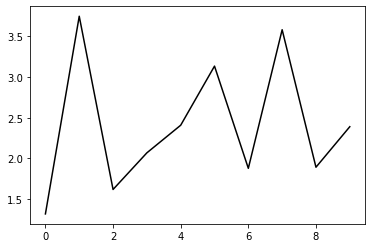

In [25]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 1.59046394e-05 -6.81729682e-04  1.31412795e-02 -1.50525136e-01
  1.14052774e+00 -6.02241647e+00  2.27455168e+01 -6.20704699e+01
  1.22166922e+02 -1.71187074e+02  1.66428955e+02 -1.07461552e+02
  4.28229887e+01 -9.20544914e+00  9.55260239e-01 -1.30911492e-04]


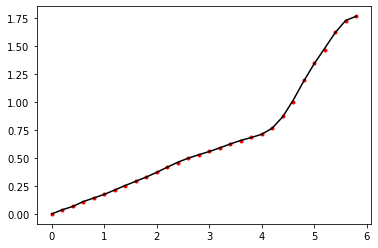

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

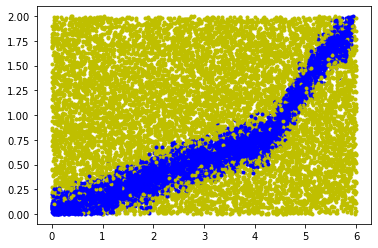

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [13]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

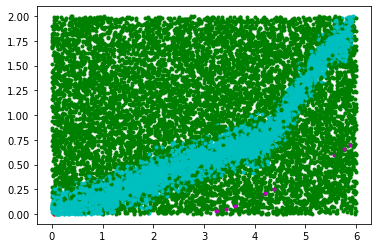

In [14]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [15]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [16]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.16483341799068, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334236233036, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246766527, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246386052, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.1648334246764105, shape=(), dtype=float64)
tf.Tensor(1.

# Optimize

100 1.5215881572047352
1.3241020852786325 0.352355378343567 0.09415609299111061 -0.2680620645156081
[1.36960444 3.69385584 1.66940964 2.01865893 2.45728106 3.08215563
 1.92872297 3.52849603 1.94233515 2.43900938]


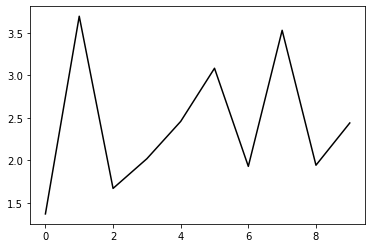

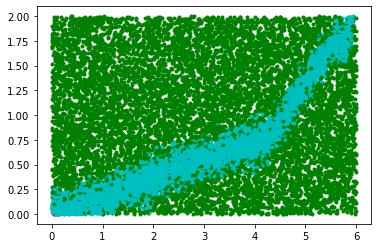

10100 0.9990379042130908
1.2029263846818778 0.1539408950777404 0.1159579783561568 -0.0073423273977494
[2.55533855 2.23875798 1.94844447 1.7070386  1.48348128 1.25455759
 1.01430247 0.79365099 0.86350881 6.76387556]


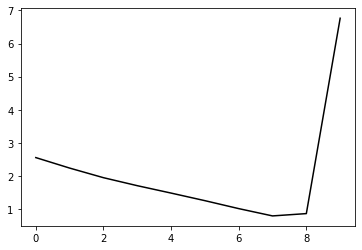

20100 0.4803962421160538
1.1530851370393522 0.04720896603782139 0.10709772512574588 0.02867266038510577
[ 2.48064253  2.32540631  2.16883391  1.91635298  1.53029126  1.00689552
  0.38668462 -0.24437    -0.45951147  7.48370197]


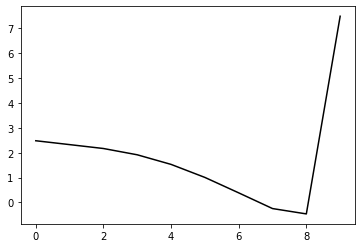

30100 0.5273949926511392
1.1313933509818874 -0.17135000767102954 0.11444467412473654 0.026478850226219965
[ 2.33603043  2.3237921   2.18303413  1.96444166  1.63793786  1.15334947
  0.45229582 -0.43564441 -0.89233203  7.36528797]


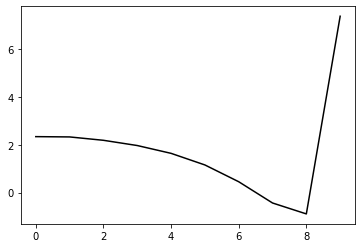

40100 0.22974976680150824
1.035172591914362 -0.48360410622412586 0.15549305718178513 0.034633179082342834
[ 2.45634335  2.21881831  1.97375153  1.68801184  1.32256712  0.80764777
  0.04376749 -1.02479376 -1.78931224  7.13403281]


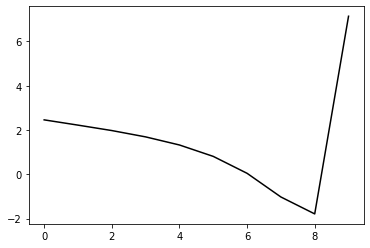

50100 0.2330798567545093
0.9726406817513885 -0.5368292078098674 0.16789109309950825 0.0448988586789683
[ 2.47605124  2.29417382  2.10331088  1.82092142  1.41405057  0.84514542
  0.03936313 -1.08615591 -1.9804164   7.08741487]


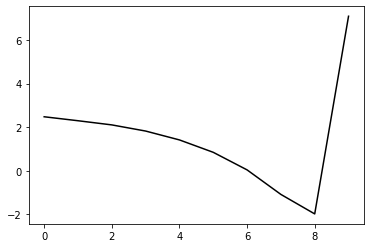

60100 0.2981954990389356
0.9179461964012623 -0.5504496810523529 0.1713816928371876 0.045715330412680256
[ 2.34497955  2.33163235  2.1811936   1.91938084  1.52654166  0.94281414
  0.05994285 -1.22707061 -2.36288784  6.97548241]


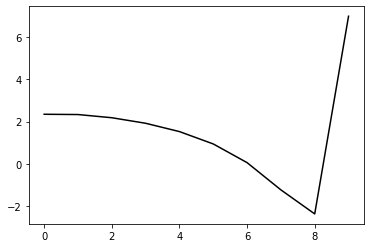

70100 0.29233288301347626
0.8595337174002642 -0.5527691085655634 0.16738832833329254 0.051970964520121184
[ 2.3624863   2.19281557  2.0654545   1.85454883  1.50551201  0.95338223
  0.07765714 -1.27224459 -2.58191884  6.95617146]


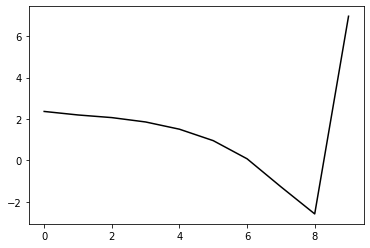

80100 0.18705693531588222
0.8124331709115132 -0.5551031845658027 0.16650406608493934 0.05296223872666865
[ 2.27586979  2.17127174  2.03501279  1.81412535  1.47319427  0.94528612
  0.09174097 -1.27709078 -2.72240701  6.89788691]


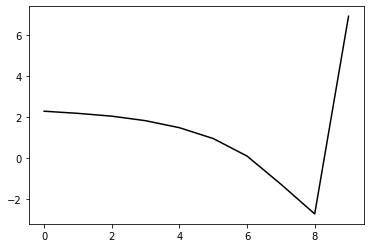

90100 0.1576766399649925
0.7722832920640677 -0.5548410980450919 0.16429272631547265 0.05403222220042118
[ 2.21906755  2.08818329  1.95575589  1.75718443  1.44437638  0.94852891
  0.13513481 -1.1985117  -2.69499111  6.92427616]


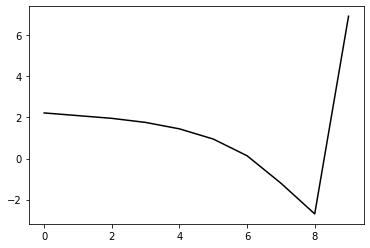

100100 0.24949627678555317
0.7258008808296609 -0.5556094942277765 0.16218542539862404 0.05821875571507294
[ 2.17200215  2.01227286  1.88613207  1.706479    1.40894032  0.92934621
  0.14365948 -1.15213285 -2.67015737  6.92541954]


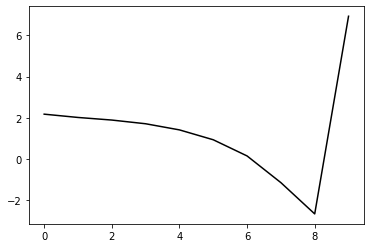

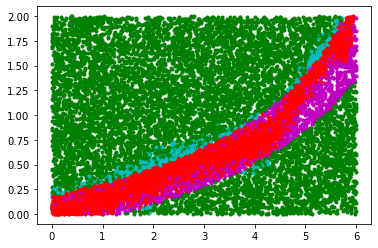

110100 0.26664176603854806
0.694975703666742 -0.5577517038135893 0.1642698088765522 0.055891798071293915
[ 2.07206059  2.0398271   1.93185955  1.73618068  1.42331191  0.94563315
  0.18237347 -1.08203254 -2.60483691  6.9223235 ]


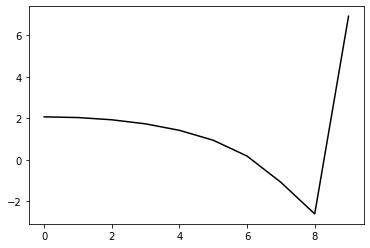

120100 0.1905820091135081
0.6534723506113432 -0.5594413189588608 0.16189260361635985 0.061273060772899866
[ 2.05133677  1.95918341  1.84285072  1.63779236  1.32155322  0.84504368
  0.08119234 -1.16951896 -2.65650529  6.93605656]


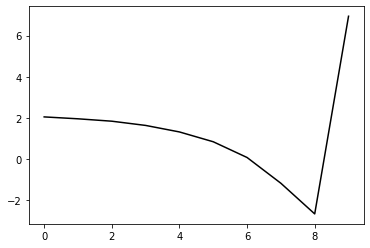

130100 0.2284260604086363
0.6184484239797642 -0.555814781911774 0.1587554683003386 0.06189221233176424
[ 1.9826361   1.87279591  1.71792846  1.51803193  1.22140479  0.76416944
  0.03245097 -1.17300352 -2.61097802  6.9389993 ]


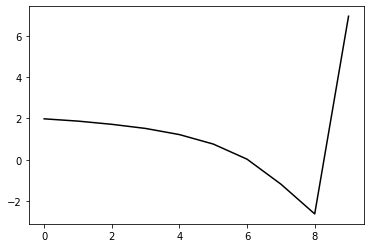

140100 0.21905786304780747
0.5995299777506621 -0.5460711451605179 0.1546925649932134 0.05794042703221968
[ 1.92114052  1.87176204  1.73296572  1.54284549  1.2602442   0.82013173
  0.11184074 -1.04917951 -2.43085     7.0229218 ]


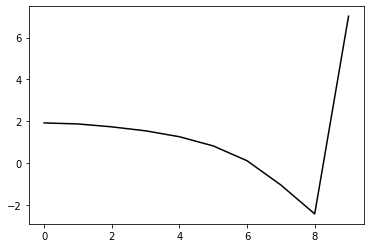

150100 0.18783789881095297
0.567553217297606 -0.5475394640496736 0.15544847145574928 0.05978487417731976
[ 1.93611046  1.8201738   1.70587473  1.52219785  1.22758699  0.77772158
  0.08795886 -1.01735246 -2.31708488  7.0019191 ]


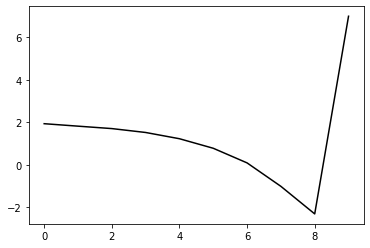

160100 0.249504547380327
0.5372442522838731 -0.5508167639485698 0.1580385919040625 0.06351172508426725
[ 1.91535933  1.80345342  1.69551743  1.5158882   1.21716933  0.76372275
  0.07189344 -1.01111596 -2.22805037  7.03346928]


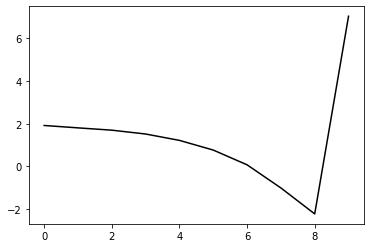

170100 0.129727636736375
0.516118975945294 -0.5432980924446238 0.15497598221538428 0.06240567145662356
[ 1.84678395  1.76603128  1.62929462  1.44097969  1.14657886  0.70806409
  0.03961791 -1.0204274  -2.18834209  7.00441502]


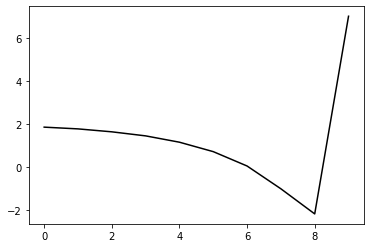

180100 0.1917479598225907
0.5054269218046159 -0.5402295544732824 0.15674328596510614 0.06477156046215925
[ 1.7816435   1.74216751  1.64747209  1.48402303  1.21821363  0.81259617
  0.1745196  -0.85861854 -1.97751178  7.12374208]


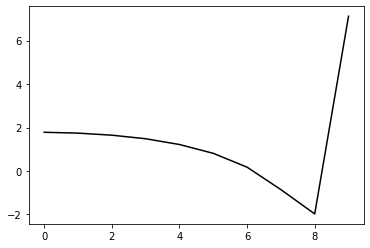

190100 0.17502014423617598
0.47766097625822085 -0.5383665423071651 0.154812269632081 0.06680750226123709
[ 1.78413898  1.70345593  1.58244406  1.39882694  1.10780539  0.68771915
  0.06284786 -0.91910945 -1.96535242  7.07911001]


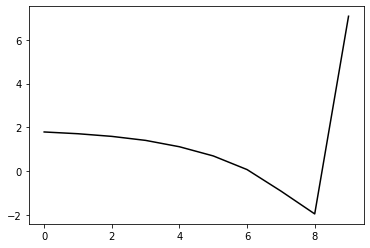

200100 0.18026361069887714
0.46236661353936526 -0.5316848818837373 0.153195250689206 0.0666875001417754
[ 1.75590924  1.6616628   1.54005703  1.36637662  1.09050575  0.68148434
  0.06087667 -0.91052031 -1.91302612  7.08222164]


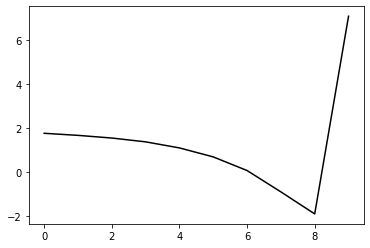

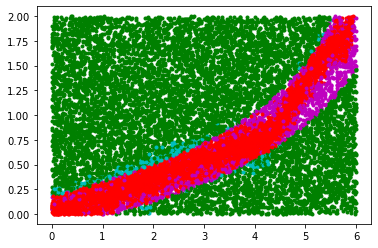

210100 0.20113244071709832
0.441712697001917 -0.5293403711356801 0.1513279333976669 0.06424916128164043
[ 1.73983009  1.6294109   1.48434925  1.28796655  1.01758625  0.63649025
  0.06448893 -0.84472366 -1.76779922  7.14677421]


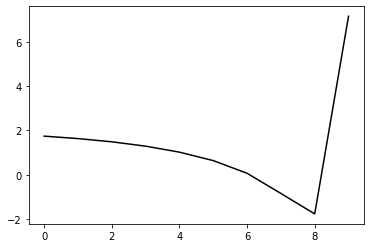

220100 0.18975534873371347
0.4297790439168064 -0.5250829703281952 0.15062983748159572 0.06379821362744492
[ 1.73591631  1.59518382  1.47414483  1.29455887  1.01508132  0.61474659
  0.04060286 -0.83276492 -1.67362769  7.14109743]


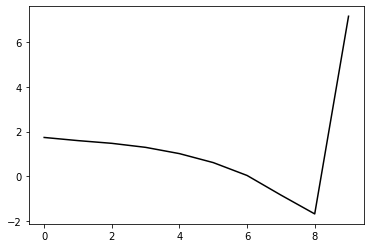

230100 0.18201841840599822
0.4083076829653531 -0.5211183101333715 0.14890530956927667 0.06581037330939925
[ 1.71091857  1.61506928  1.47231426  1.2831902   1.01421403  0.63351353
  0.06995064 -0.78470477 -1.56561624  7.20998136]


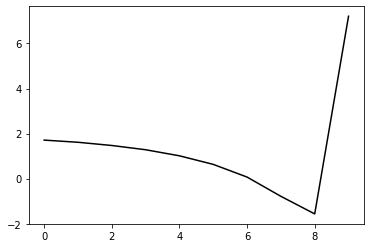

240100 0.19197552782917557
0.39549223123137256 -0.5120605152434101 0.14606095359840127 0.06312396078904228
[ 1.67724285  1.54365598  1.41038993  1.24951299  1.01134119  0.6454409
  0.08021708 -0.76397968 -1.49207314  7.21924492]


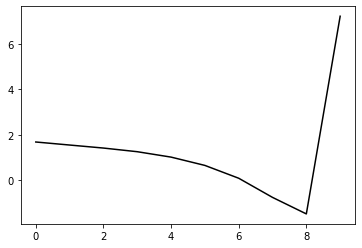

250100 0.31793301991963985
0.374618877970667 -0.5134401353924634 0.14769932525815505 0.06838455591401581
[ 1.66591926  1.49426781  1.3640064   1.1881578   0.94151818  0.58358767
  0.04352866 -0.76220973 -1.42977766  7.23570249]


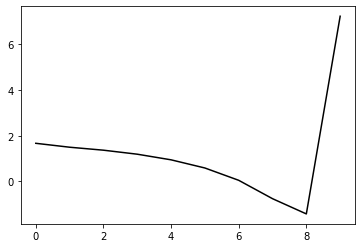

260100 0.14900975185225201
0.3657797505798824 -0.5137803059732182 0.15129178199609541 0.06893682897801158
[ 1.631343    1.49906067  1.38107658  1.21751482  0.95624121  0.58877758
  0.06093139 -0.72365208 -1.34714475  7.25168586]


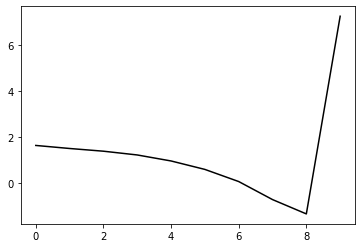

270100 0.1560615514969921
0.35978011993938197 -0.4999582032089554 0.1463325674670244 0.06981162232273068
[ 1.58372677  1.48508946  1.35407429  1.17980691  0.93159926  0.56992131
  0.01839611 -0.79504296 -1.42433622  7.1927929 ]


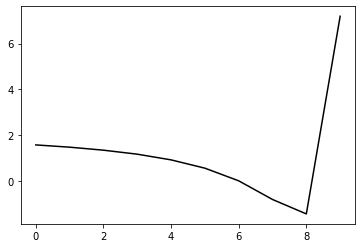

280100 0.24098981681785442
0.34198361303937447 -0.4997400550476234 0.1479063953728947 0.07125239820588793
[ 1.62135562  1.44092036  1.30404778  1.16403059  0.95481224  0.62742809
  0.11948986 -0.6379791  -1.20667386  7.26584452]


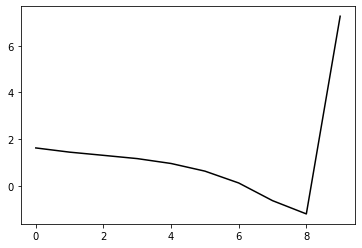

290100 0.21792115051165287
0.33498590813683843 -0.4946907817155226 0.14956897879269432 0.06633998475636588
[ 1.609793    1.52460299  1.41867193  1.25038271  1.00375601  0.65763246
  0.14911475 -0.59034436 -1.1307718   7.30962885]


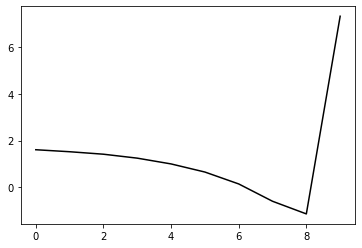

300100 0.26410860078203563
0.32900243184714056 -0.48813750541510476 0.14998317951200077 0.06547921498187265
[ 1.59612442  1.43544224  1.32382897  1.19241492  0.97572783  0.63094376
  0.12253603 -0.61064103 -1.12915631  7.3220195 ]


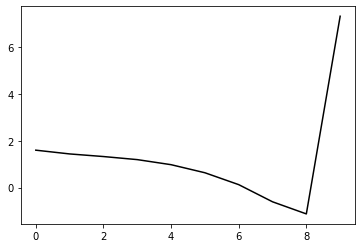

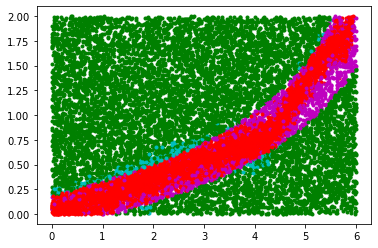

310100 0.3442355934409975
0.3172389791209568 -0.4828205236120134 0.1485054390644592 0.06763508179525096
[ 1.63120726  1.464493    1.3302966   1.20820797  1.0109757   0.68608745
  0.18092185 -0.55457962 -1.05797541  7.31148754]


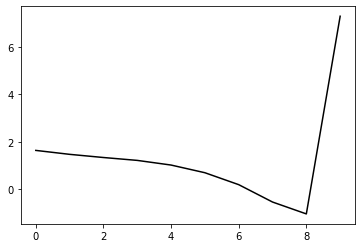

320100 0.1914711104725595
0.31056064139742623 -0.4808691082845019 0.1498253701222098 0.06417301468518401
[ 1.58194326  1.46750456  1.30156246  1.10935219  0.87534924  0.54594031
  0.06316902 -0.63956879 -1.11567167  7.30453427]


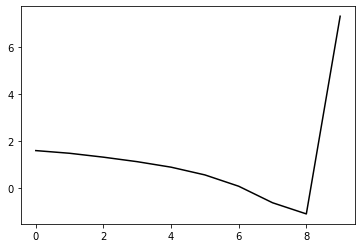

330100 0.12992515539053714
0.3048190684324801 -0.4733331537984865 0.14827984317291287 0.06379619330827994
[ 1.55920381  1.44397685  1.32192885  1.14950102  0.91140985  0.59336654
  0.13940671 -0.52853964 -0.96594957  7.3401802 ]


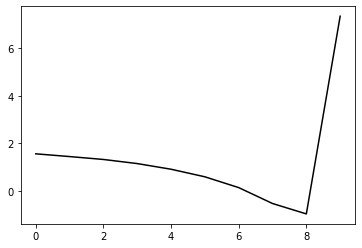

340100 0.23219982200093842
0.2904329458137757 -0.48102000356549146 0.15364210611131912 0.06267872235373875
[ 1.54481618  1.36873518  1.16183416  0.95841072  0.73140431  0.41895446
 -0.04161505 -0.69523711 -1.07798292  7.31748459]


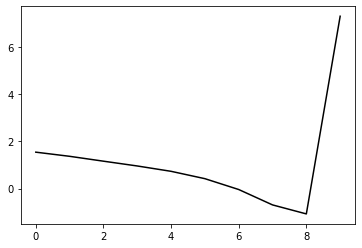

350100 0.20046497414247993
0.2867611632453772 -0.47291018599879825 0.15149609096637812 0.0664944895909472
[ 1.53999545  1.43731795  1.31148017  1.12930262  0.89542179  0.56883112
  0.0879184  -0.58854363 -0.96579817  7.34793304]


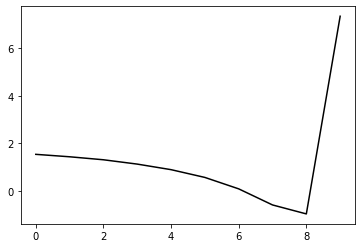

360100 0.2941600283933692
0.27647500081479964 -0.4682309033493987 0.14974311963557707 0.06754133592748558
[ 1.51891689  1.37880673  1.21188708  1.03091445  0.81672874  0.51572756
  0.06686883 -0.5787773  -0.93797774  7.34161627]


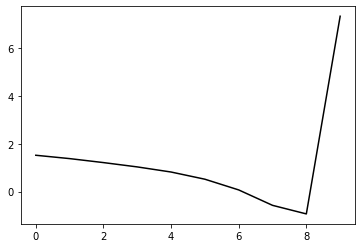

370100 0.2205233223061256
0.2771402593991922 -0.46304445554173845 0.15076545211286294 0.06880914106001376
[ 1.47537846  1.35298492  1.27614766  1.13431134  0.89599588  0.55572623
  0.06837673 -0.60356069 -0.96431576  7.31893274]


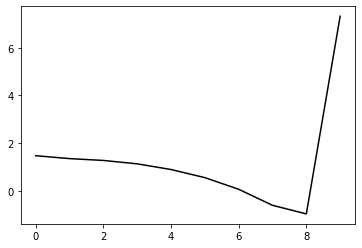

380100 0.2144990925390503
0.2650415887674167 -0.45863856521741303 0.14920317334808994 0.07142973299666056
[ 1.48740918  1.32843366  1.19522038  1.07891303  0.90061586  0.61202532
  0.16875818 -0.47792112 -0.83254833  7.36989258]


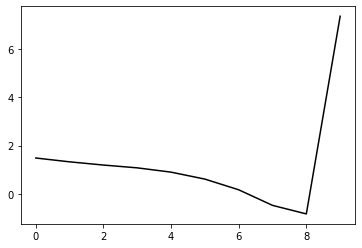

390100 0.20464474993015994
0.2647567646744375 -0.45467277337321566 0.15046909268060818 0.06930370066554958
[ 1.43370977  1.36327616  1.26173616  1.1042958   0.85895007  0.53634016
  0.09482441 -0.52561917 -0.85824243  7.33377877]


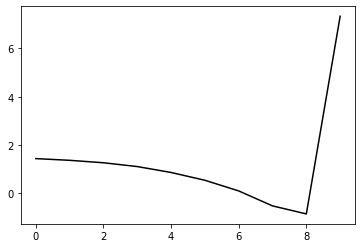

400100 0.19120114175376368
0.2501669961294375 -0.45095194909201125 0.14829343997238478 0.06832755837635915
[ 1.45306197  1.31583474  1.18947628  1.02074129  0.80134638  0.50707308
  0.08066776 -0.51714642 -0.80445083  7.42065184]


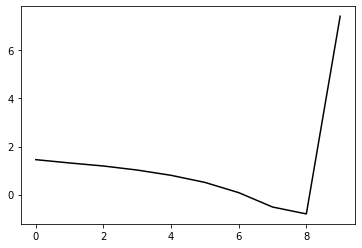

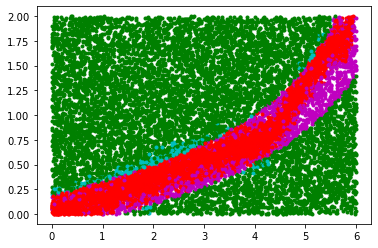

410100 0.20895498318361866
0.25214005933291705 -0.44827780115065113 0.15154971471222148 0.07047427364333396
[ 1.4094824   1.31984435  1.20043493  1.04567695  0.82081383  0.51789828
  0.07900956 -0.52880768 -0.80062948  7.34963074]


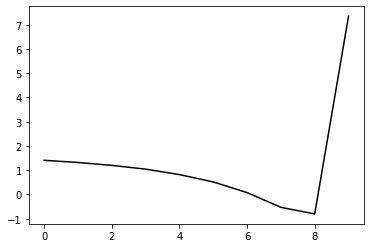

420100 0.2085269235859936
0.24736116414413095 -0.4392964026196393 0.14861944694858323 0.06776530454745808
[ 1.4353383   1.28453896  1.17053704  1.03006282  0.82939045  0.53472676
  0.09891379 -0.51056753 -0.79789344  7.38654918]


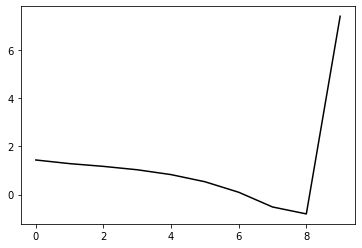

430100 0.16589292902774744
0.2387266882913594 -0.4413314235108419 0.15230421438345543 0.06905288015510207
[ 1.40453177  1.31212666  1.20216042  1.06066422  0.84025392  0.52999488
  0.09117431 -0.51078601 -0.78219996  7.44085247]


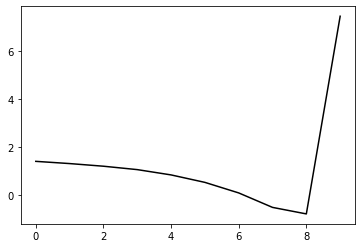

440100 0.19599471482643352
0.2349088637725816 -0.4346581260856269 0.150494588436441 0.06984382230752542
[ 1.40755919  1.35115279  1.24881214  1.09877167  0.89842022  0.60630009
  0.16850676 -0.44463396 -0.72780402  7.38037565]


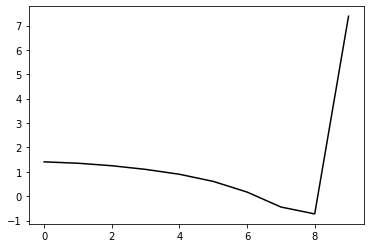

450100 0.15597007526005924
0.23691241033118218 -0.4271437373517883 0.1501697502413123 0.06656879101341073
[ 1.37490323  1.31319849  1.22356842  1.10854327  0.92852452  0.64779315
  0.22177854 -0.38334723 -0.66459176  7.41205426]


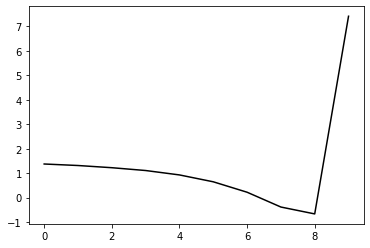

460100 0.3227044500421539
0.228828473771784 -0.4269631678413485 0.15142044498522314 0.0689958332219072
[ 1.43849888  1.28260227  1.17808977  1.06421132  0.89722372  0.62908046
  0.21532213 -0.36025248 -0.6069833   7.44014898]


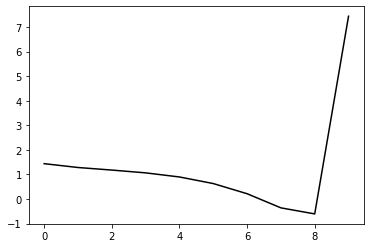

470100 0.1802517147906297
0.22958393436315924 -0.4263576450906587 0.15412403423045198 0.06797383512216021
[ 1.40961125  1.28987936  1.20290539  1.0538242   0.83010887  0.5450219
  0.14301579 -0.42462702 -0.65624468  7.40775269]


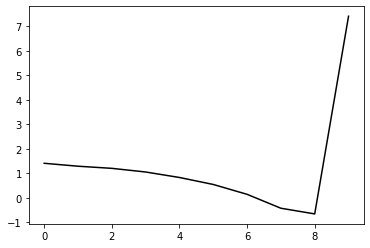

480100 0.1831070122257584
0.231347496283038 -0.4178676121322526 0.1521304943891644 0.0678857743210058
[ 1.41014759  1.31038997  1.23133199  1.07632595  0.83479181  0.52352565
  0.11371474 -0.43682799 -0.64147101  7.3832629 ]


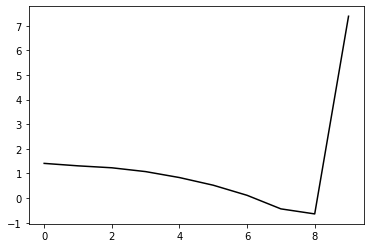

490100 0.18497437681692866
0.22427677626713263 -0.4164885493084533 0.1528583063726025 0.07028575396175418
[ 1.40410926  1.33264987  1.23659692  1.08085809  0.85475994  0.55612279
  0.14082659 -0.42115708 -0.61935494  7.42353045]


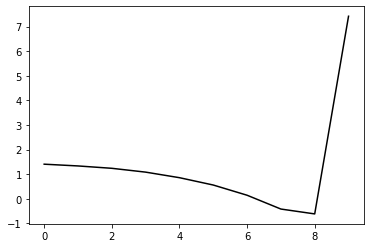

500100 0.25407731420286
0.22688300002370743 -0.4100110556682039 0.15298881419924196 0.06768631184296016
[ 1.39403617  1.31877369  1.22849721  1.08369758  0.85409703  0.55437176
  0.14458981 -0.41368077 -0.60548697  7.39424653]


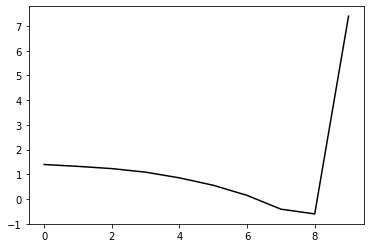

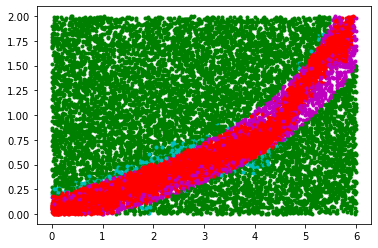

510100 0.1976990107384112
0.22093343601109505 -0.40915135269926145 0.1538159835156147 0.06614249870589538
[ 1.40662402  1.25504739  1.15134032  1.01690231  0.81032226  0.51496093
  0.10140518 -0.4415146  -0.60628486  7.41747882]


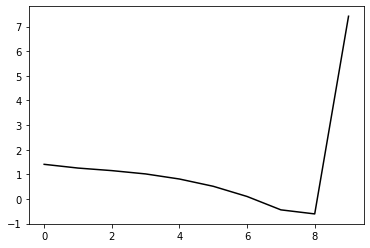

520100 0.2722571214262693
0.21953310193158343 -0.4085668891508282 0.15597268364433864 0.07023812817952424
[ 1.4116936   1.35244024  1.2788456   1.13699682  0.90384023  0.58057894
  0.14743615 -0.40203731 -0.55565266  7.41602397]


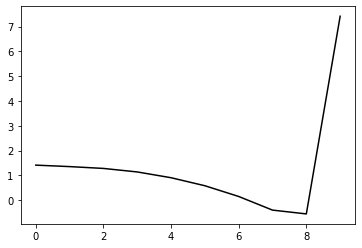

530100 0.13584266066564946
0.21982095744120417 -0.40481772150837303 0.15714350223715318 0.06811392455698076
[ 1.40807161  1.29033785  1.2031074   1.07252934  0.85689344  0.55681543
  0.14377716 -0.41600618 -0.58151981  7.4647806 ]


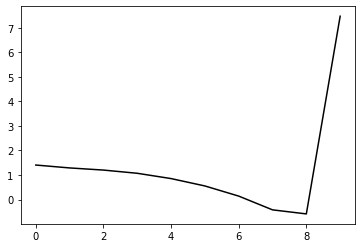

540100 0.24967988436396038
0.21985906797916413 -0.3939331726781399 0.1531309481635544 0.06537117985925857
[ 1.42586572  1.29179231  1.17661637  1.0572283   0.88362826  0.60075803
  0.16614339 -0.42426517 -0.63048711  7.39790767]


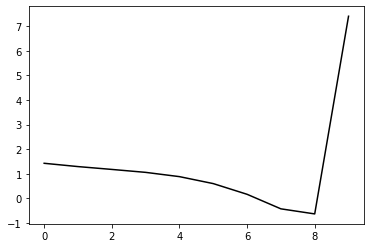

550100 0.1998914860596321
0.217424689030117 -0.39233188587522005 0.1540595364123621 0.06505225514423915
[ 1.35239576  1.25761027  1.14972338  1.00905921  0.7922392   0.50375951
  0.11282602 -0.42836857 -0.61163941  7.3923643 ]


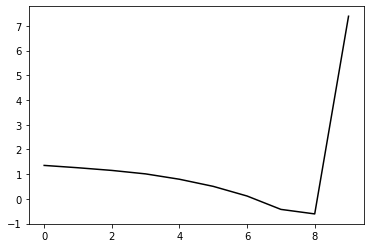

560100 0.2719641578782373
0.210324381351212 -0.39379940414456277 0.15665773785588152 0.06690918603234997
[ 1.40567387  1.27704248  1.10438804  0.93794662  0.74952096  0.46943835
  0.05030389 -0.50592815 -0.67416627  7.41402608]


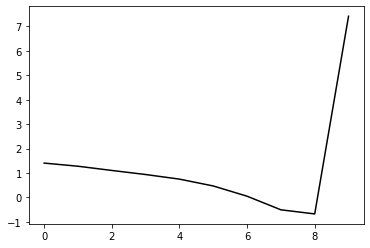

570100 0.18161070754363132
0.211058526314184 -0.38709706038598035 0.15680098842731596 0.06775609155543248
[ 1.3851388   1.25933208  1.17508713  1.05225288  0.84606048  0.55184938
  0.14613946 -0.39954573 -0.56545563  7.43422049]


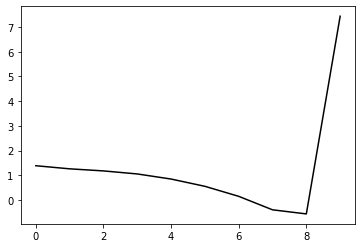

580100 0.17938589022221782
0.20606433004535152 -0.3828450972155943 0.15547597854954304 0.06961504158790208
[ 1.3639522   1.21095858  1.11792382  0.99845925  0.79719139  0.50642403
  0.09406385 -0.4656599  -0.64550098  7.42436812]


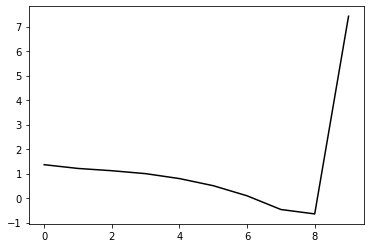

590100 0.19441574896704436
0.20730721533625904 -0.3808015693450979 0.1582728936297119 0.06711190116800328
[ 1.33722816  1.33354618  1.25043798  1.12860886  0.93749528  0.65440414
  0.24544444 -0.3024022  -0.47750616  7.44661821]


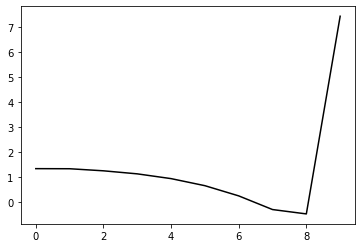

600100 0.17782833494357572
0.20503103260557629 -0.3781083528264607 0.15823455746911833 0.07230958807811777
[ 1.37190445  1.28829644  1.21071735  1.08607173  0.87287976  0.57564594
  0.16819687 -0.38013999 -0.54522307  7.42408658]


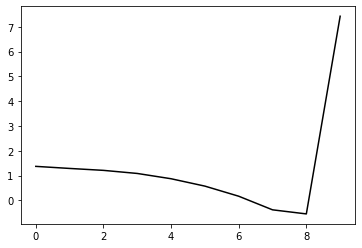

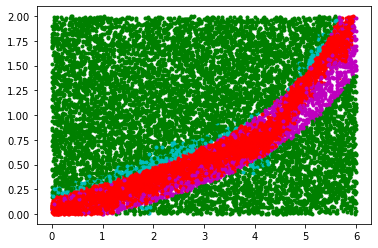

610100 0.23832602736684283
0.19857477104351023 -0.3747158276803757 0.15726971975855963 0.07200584787397991
[ 1.38683206  1.24135727  1.10781498  0.99555794  0.84039382  0.57684092
  0.16782191 -0.37673741 -0.52788161  7.43566107]


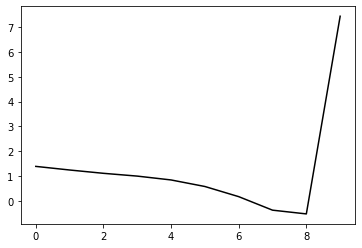

620100 0.18615839914518048
0.2018838223537769 -0.37177355529372313 0.15916135630543482 0.07229888212607638
[ 1.37773895  1.28359273  1.21075312  1.07803913  0.86184064  0.57140207
  0.17589009 -0.35276716 -0.49099267  7.44638957]


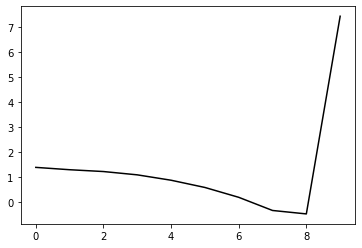

630100 0.17076632094073455
0.20461534885625307 -0.3685754322932025 0.1606756360539275 0.07077408027261385
[ 1.35890499  1.2761611   1.18898293  1.04904788  0.82308925  0.51810896
  0.09969744 -0.45517737 -0.60945377  7.40124473]


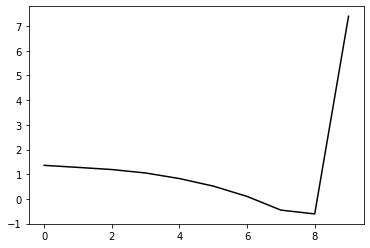

640100 0.26751295773236194
0.20471387211751998 -0.36688707806304816 0.16067940258925564 0.07148637626317908
[ 1.34599119  1.27223216  1.17295656  1.00118473  0.76697186  0.48188583
  0.08920669 -0.44329825 -0.58075707  7.3990192 ]


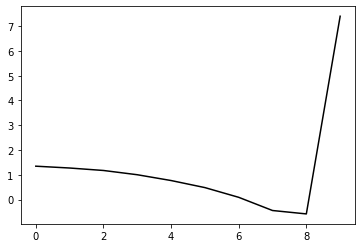

650100 0.23386715114325404
0.19982625015417488 -0.36458921536650185 0.1603887666802664 0.07204077586724421
[ 1.36879128  1.29412043  1.1930711   1.01980202  0.78743835  0.50507331
  0.11917351 -0.39113173 -0.50160322  7.43006863]


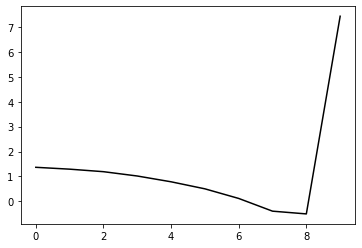

660100 0.21115755619832519
0.20811400415154094 -0.3597083844861397 0.16157771168645135 0.0675082159798277
[ 1.331295    1.26557464  1.17652074  1.04966808  0.84915155  0.55240029
  0.13143611 -0.41613974 -0.54811736  7.45257057]


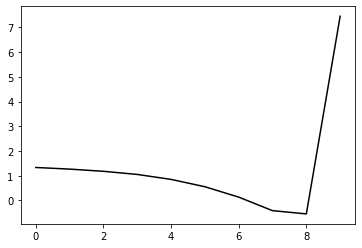

670100 0.2926748935996814
0.20469477572978007 -0.3544635180129789 0.15953874347433764 0.06625034233525996
[ 1.3493388   1.24144224  1.12075596  0.9840286   0.78797627  0.50310194
  0.08548989 -0.48273641 -0.64899275  7.42644976]


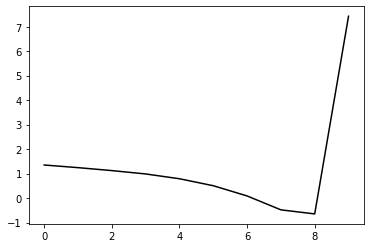

680100 0.21514120790738664
0.20677723359532446 -0.35348531133442423 0.16191588179745023 0.07065644382082298
[ 1.37693168  1.24227462  1.15220586  1.01814546  0.8044379   0.50374674
  0.08203884 -0.48162091 -0.64544326  7.42354297]


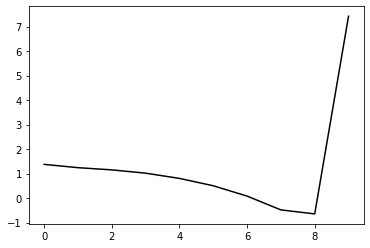

690100 0.17447669860746193
0.20562050095400283 -0.35305493283769207 0.16371767252079328 0.07218722939788344
[ 1.34611872  1.2568357   1.14945783  1.00892508  0.79153858  0.48301882
  0.04940015 -0.51715603 -0.6763368   7.3728706 ]


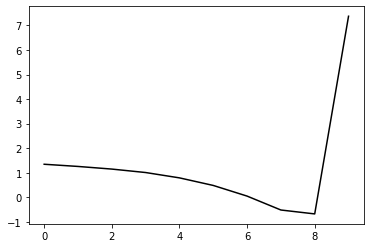

700100 0.1556167251781284
0.2071194880313477 -0.34609399500987836 0.16287944333160037 0.07184376027369199
[ 1.35604798  1.25377762  1.19185463  1.0604554   0.83954355  0.53168687
  0.09983261 -0.47432083 -0.64655281  7.40082852]


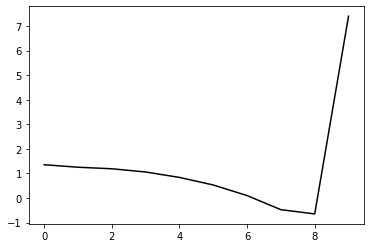

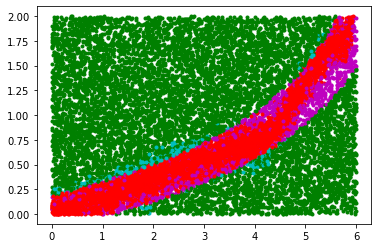

710100 0.25024916797421803
0.2027721421616123 -0.3464674279014873 0.16432059904778126 0.07356499725825046
[ 1.39258443  1.28004476  1.19365569  1.06318648  0.86951375  0.59833706
  0.19274486 -0.37879078 -0.56340027  7.42150277]


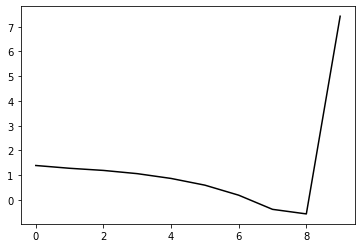

720100 0.17689390368888894
0.20396026734508518 -0.3462692982109192 0.1655636895448948 0.07453889254913267
[ 1.36890218  1.3074275   1.2211767   1.0679108   0.83537748  0.53379157
  0.11893271 -0.44679834 -0.63657604  7.39625789]


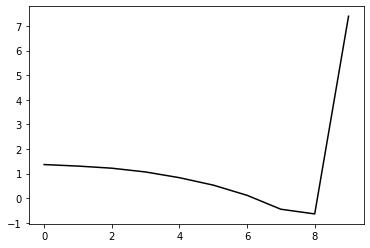

730100 0.2031887932984323
0.20528676508824414 -0.3433488851930477 0.16543257175686987 0.07493133362772665
[ 1.34653276e+00  1.24265709e+00  1.16931079e+00  1.02350010e+00
  7.79066111e-01  4.44914015e-01 -2.51606972e-03 -5.85079043e-01
 -7.72722080e-01  7.37022330e+00]


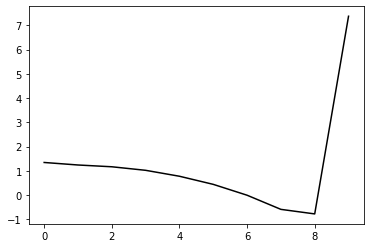

740100 0.2931325648899225
0.20274212383355306 -0.3434739753764881 0.16623753560167126 0.07755533872884046
[ 1.3482912   1.24877143  1.16697533  1.02649676  0.80400487  0.50179636
  0.07222481 -0.51756635 -0.71013699  7.39269541]


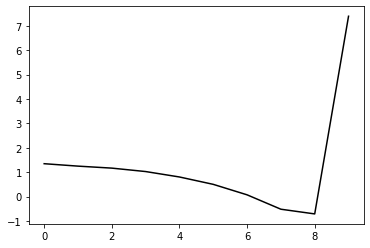

750100 0.161275699278949
0.20405679638095595 -0.3359725232639164 0.16474957499895962 0.07210675808707472
[ 1.34277777  1.21456052  1.13531638  1.00520949  0.78124409  0.47257729
  0.03941496 -0.55349618 -0.76971681  7.40359302]


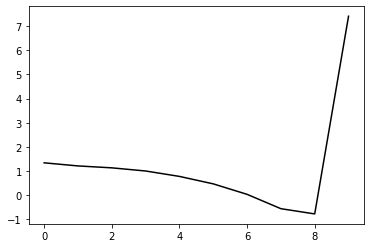

760100 0.1994244861347656
0.2050349474009646 -0.3323724666402252 0.16447303341948757 0.07285423337118234
[ 1.34743175  1.22182842  1.13748646  1.01374001  0.79818726  0.47871649
  0.02616309 -0.58325363 -0.82027256  7.38670024]


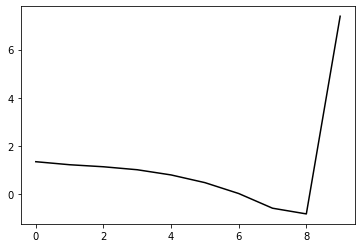

770100 0.15425036645122572
0.19947864581434313 -0.3369317718890794 0.1672268259552961 0.07634768186014826
[ 1.34427357  1.27870465  1.19002668  1.04261391  0.81559095  0.51051812
  0.08666545 -0.48936012 -0.69370157  7.37924665]


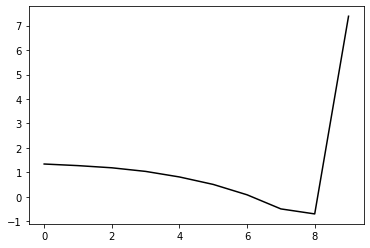

780100 0.15084789741496046
0.20363658354582298 -0.33378835598735523 0.1669496313202927 0.07647554638130258
[ 1.32980631e+00  1.22989748e+00  1.13479351e+00  9.75764456e-01
  7.42776525e-01  4.35213142e-01 -3.59298427e-03 -5.99973531e-01
 -8.12785698e-01  7.34078640e+00]


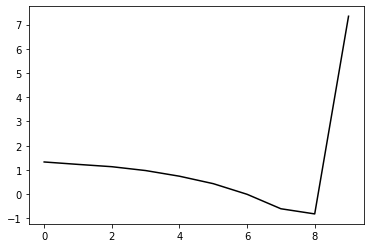

790100 0.11345312817966147
0.2027064250070009 -0.3333490483989485 0.1683936353984832 0.07836171573320866
[ 1.3166603   1.18366577  1.09559968  0.95387936  0.72565959  0.409407
 -0.03947386 -0.64814621 -0.87233441  7.35716804]


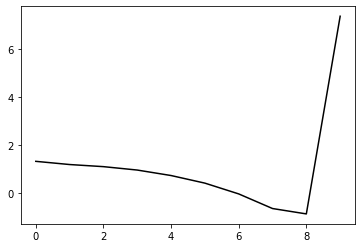

800100 0.20460431773460094
0.20042673844463998 -0.329914753012161 0.16776787313932165 0.07818152795815553
[ 1.31205064  1.21732486  1.12605995  0.96499958  0.73188626  0.42482565
 -0.01621083 -0.62428596 -0.86604446  7.33104235]


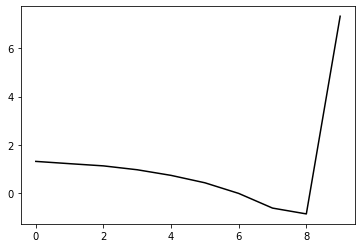

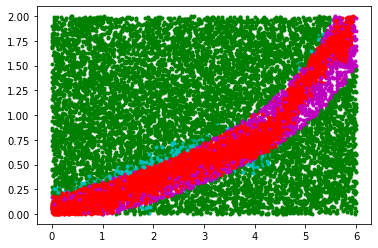

810100 0.22602445393121895
0.19652242761922298 -0.3285407388934283 0.1685060199138287 0.0740078233654834
[ 1.3359232   1.19139527  1.08172117  0.94802839  0.75606783  0.47629885
  0.0764254  -0.47908546 -0.68949431  7.41391313]


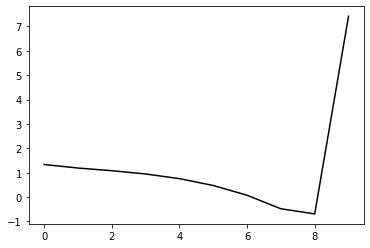

820100 0.2542688863614209
0.1957311355296853 -0.3268407937770616 0.16952216857671784 0.07816826517660198
[ 1.33903714  1.24566405  1.16087869  1.00850118  0.77763662  0.47191259
  0.04265951 -0.52684156 -0.72101822  7.37312332]


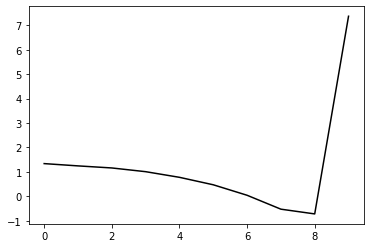

830100 0.24852115798528446
0.1934243137430292 -0.31879275717479394 0.16644252413008964 0.07293892649751514
[ 1.33821486  1.20461747  1.09863409  0.96156407  0.76505347  0.47927157
  0.05888238 -0.52345913 -0.74318333  7.39103363]


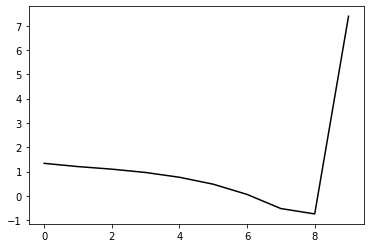

840100 0.2484750935000594
0.18939788038859143 -0.32242193652140533 0.16993992675286634 0.07324932874257552
[ 1.31944786  1.16569418  1.02629494  0.88305028  0.69072505  0.40541773
 -0.01725268 -0.59146156 -0.7885982   7.36889648]


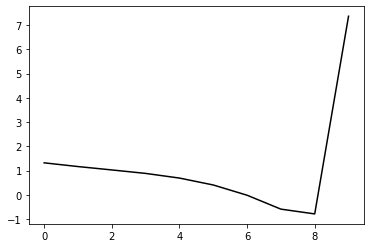

850100 0.2242395617742549
0.18497765037163247 -0.3187781881355231 0.16898369937520374 0.07581435702663263
[ 1.3598587   1.21557196  1.08438943  0.95738187  0.77710197  0.49813114
  0.07675308 -0.4980598  -0.69502901  7.42576654]


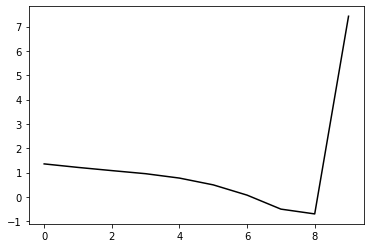

860100 0.19078756827567744
0.18805882908271926 -0.31689241044911776 0.1702630381740346 0.07546691260400333
[ 1.36072896  1.1925205   1.08038959  0.97643774  0.79808213  0.50771572
  0.08413512 -0.48646346 -0.67893439  7.39943331]


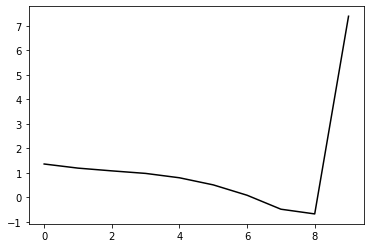

870100 0.21608242601731695
0.19371109973570302 -0.3123899948452464 0.1707593246870863 0.0759791573609907
[ 1.31930922  1.23616224  1.14276149  1.00792718  0.78452958  0.46835794
  0.02952871 -0.55214138 -0.7492516   7.36101096]


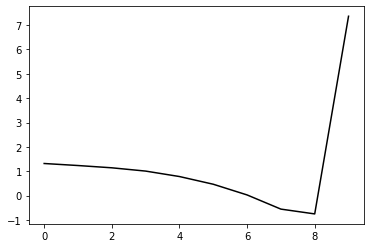

880100 0.23666030952287184
0.18652425750694318 -0.3121665458815254 0.16996663104495371 0.07686120884376622
[ 1.31155818  1.22491421  1.11419268  0.96018791  0.752762    0.44816371
  0.00844059 -0.58172145 -0.79350826  7.35127553]


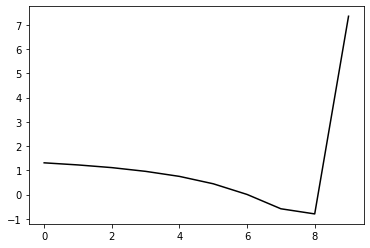

890100 0.13144675584627596
0.18680848009526055 -0.30905663030555675 0.1709871580937456 0.07374084171902362
[ 1.30971596  1.18735111  1.10596161  0.97462017  0.75975716  0.46481439
  0.05168915 -0.5186918  -0.72976894  7.4221022 ]


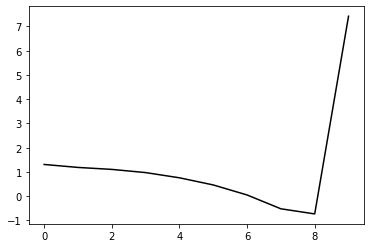

900100 0.17754762438817004
0.1822867607334395 -0.3100824835592055 0.1716269744175468 0.07643169796545973
[ 1.31765848  1.25315385  1.17191704  1.03033303  0.81075262  0.51968522
  0.11237646 -0.44701591 -0.64065727  7.40094132]


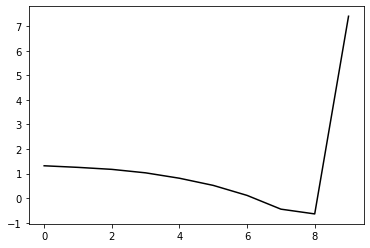

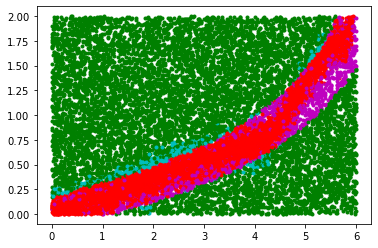

910100 0.21990125880924885
0.18335484316876333 -0.30716806419379183 0.17061870754286357 0.07629218416809241
[ 1.29258626  1.21584114  1.13095225  0.97941136  0.74553143  0.44184892
  0.02572826 -0.5390257  -0.73295015  7.36586577]


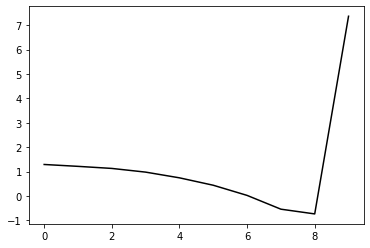

920100 0.24603698927414702
0.1844643825335602 -0.3027755622287397 0.16975709330287095 0.07447263030548322
[ 1.31337669e+00  1.18495799e+00  1.08139708e+00  9.47250724e-01
  7.44198898e-01  4.43468540e-01  6.47850291e-03 -5.76933957e-01
 -7.80951818e-01  7.38188048e+00]


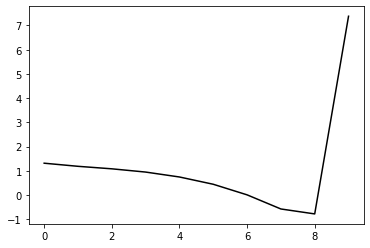

930100 0.1736841125071412
0.18366060457338246 -0.30295719907375623 0.17111917466826637 0.07508776057373111
[ 1.29998366  1.22401805  1.1372242   0.98747118  0.75650754  0.45865713
  0.0493412  -0.51736516 -0.71651181  7.36605899]


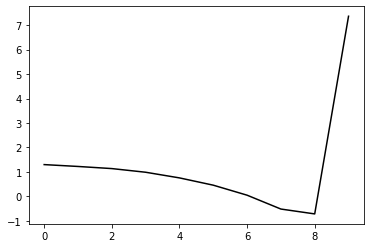

940100 0.17219282379619424
0.18375508385292585 -0.30346689992013925 0.1719374328471607 0.07492001130412951
[ 1.30398449  1.21438227  1.12702328  0.97960129  0.74574323  0.43272931
  0.00863006 -0.55045736 -0.72647537  7.36124683]


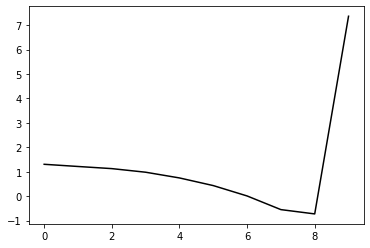

950100 0.25465353405311886
0.17969979302623262 -0.30572843578015585 0.1744340260906125 0.0714049407913365
[ 1.29330364  1.26494715  1.16318403  1.00741976  0.7936096   0.49095748
  0.07216436 -0.47853349 -0.63953369  7.41690376]


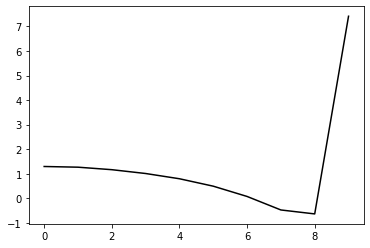

960100 0.21532446807396816
0.17980801415845146 -0.2996268442068592 0.17091834101951198 0.07584207539113545
[ 1.27599228  1.19862538  1.09115284  0.93997404  0.71904818  0.40736382
 -0.03339069 -0.61221728 -0.77949658  7.40807065]


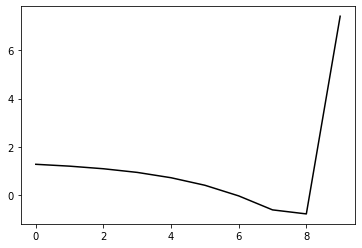

970100 0.19518645221864578
0.18203274825510507 -0.2994911432203877 0.17289510746268688 0.07564338856782522
[ 1.29134125e+00  1.20088682e+00  1.09287060e+00  9.54138926e-01
  7.49061987e-01  4.45373542e-01 -1.99634253e-03 -6.04985163e-01
 -8.02821824e-01  7.36361628e+00]


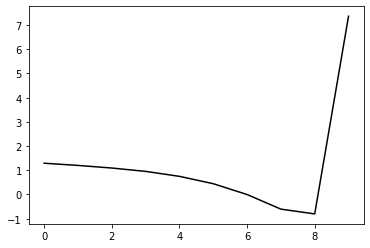

980100 0.2549828387730782
0.18378310901839 -0.29792017006328164 0.17426638581958073 0.07748525064846108
[ 1.33033434  1.25318497  1.17013424  1.04322959  0.83545991  0.53405537
  0.09779378 -0.49548925 -0.70624812  7.43953234]


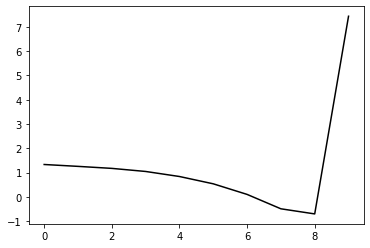

990100 0.2161955737301453
0.18016810429598684 -0.29536241988259543 0.17302036059959172 0.07708757677546274
[ 1.3638053   1.22414069  1.09756718  0.97853323  0.80215113  0.522975
  0.1005384  -0.48662698 -0.70129119  7.42400425]


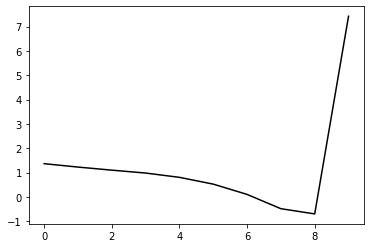

In [26]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print((j+1)*100, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

0 0.2339756929375507
0.1921074504022513 -0.2865260823063437 0.1662463535459569 0.06595057273837224
[ 1.28703461e+00  1.19436756e+00  1.09325891e+00  9.36917820e-01
  7.24701018e-01  4.28447552e-01  3.89217099e-03 -5.72516135e-01
 -7.81577014e-01  7.42879348e+00]


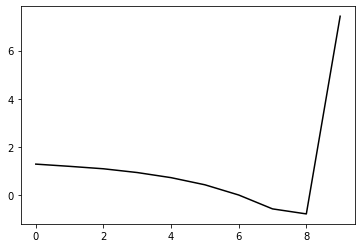

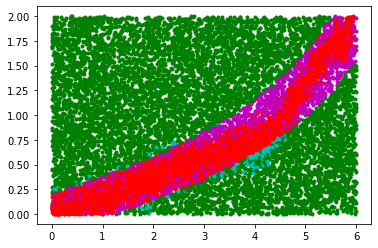

1000 0.20624919228843236
0.20297191495961683 -0.2984319404657404 0.18008018368283077 0.07954382275494408
[ 1.26130582  1.186084    1.07689858  0.92633084  0.69066744  0.36063498
 -0.08884496 -0.67371235 -0.85633308  7.34717579]


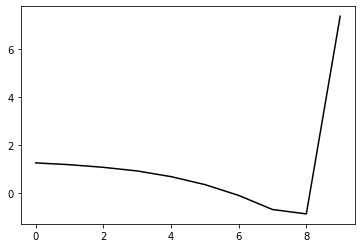

2000 0.2817630339317652
0.19868272101106854 -0.28853934713580887 0.17549680007204435 0.07930162737434245
[ 1.30647745  1.14746814  1.0109148   0.85741851  0.6422484   0.3193345
 -0.1633597  -0.81673396 -1.05702898  7.3141635 ]


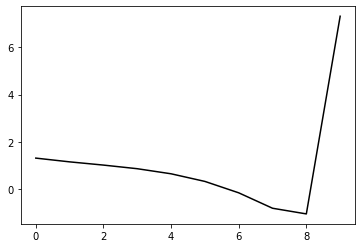

3000 0.18899878050352054
0.19532004735067418 -0.28633602506742445 0.17638506129866888 0.07600970208268763
[ 1.29701982  1.14972702  1.02706983  0.88445066  0.6832112   0.38013502
 -0.07428922 -0.7146928  -0.9941746   7.33274129]


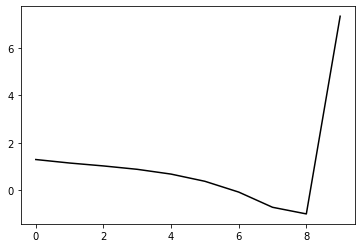

4000 0.24258721429862454
0.18800640626593978 -0.2883254258839941 0.17782960949572083 0.08035949369376447
[ 1.34090533  1.17692969  1.02925074  0.89674335  0.71248803  0.4212876
 -0.02612327 -0.63778366 -0.88520379  7.36518779]


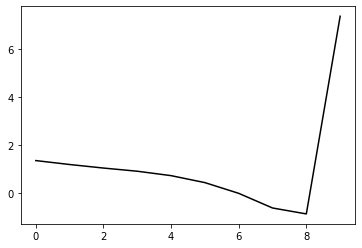

5000 0.19708938565991554
0.18472060454656627 -0.2850890607585432 0.17702031150020583 0.07938375362258954
[ 1.31447742  1.20179759  1.08277781  0.92413262  0.71131535  0.38982669
 -0.08273406 -0.71080017 -0.96961288  7.34100031]


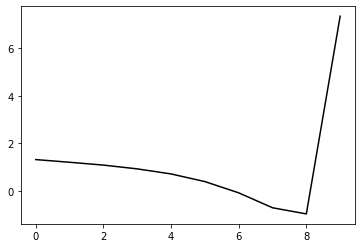

6000 0.19169478947885235
0.18464702938648203 -0.28475801605359796 0.17871396789356184 0.0794823619823959
[ 1.28618871  1.19602941  1.08486717  0.9374571   0.71716637  0.41450028
 -0.03488152 -0.67059752 -0.94257869  7.31991419]


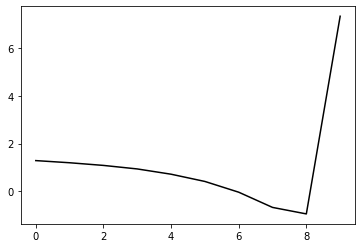

7000 0.21210408487456472
0.17672825577893045 -0.2860646925062612 0.1806238257006539 0.07568707874986741
[ 1.26456722  1.21145265  1.07977462  0.91141551  0.71739765  0.44311293
  0.0253326  -0.56191193 -0.79952503  7.3916358 ]


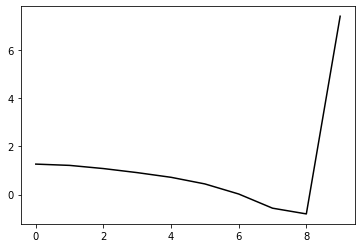

8000 0.21797437061225497
0.17369315401639965 -0.2799095176278494 0.1771141634103714 0.07917887070042047
[ 1.32660518  1.17707479  1.04553545  0.92403606  0.7473935   0.46439715
  0.03510199 -0.55651207 -0.78861485  7.36980545]


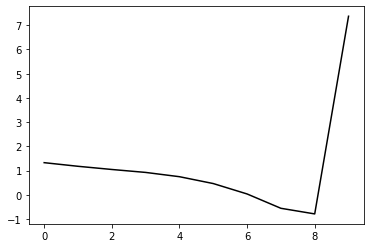

9000 0.17577140878854133
0.17524112713444842 -0.28156831746954447 0.1799716993472861 0.07532781733942294
[ 1.29618189  1.16932901  1.07444287  0.93188645  0.71729604  0.42972281
  0.02983772 -0.51812641 -0.70463389  7.36264681]


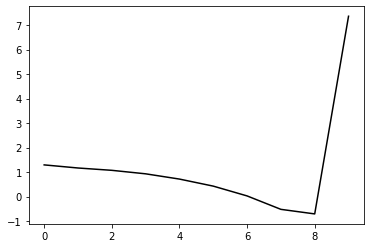

10000 0.21541722617730716
0.17384974788536386 -0.27960773066506156 0.1787263635187748 0.07854324593872121
[ 1.29851383  1.22929289  1.1435387   0.99159022  0.75875714  0.45549974
  0.04180679 -0.51323216 -0.68648603  7.38428165]


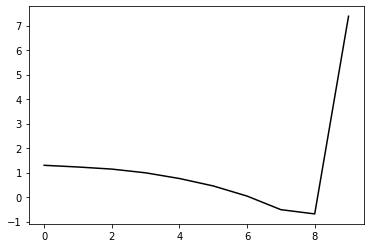

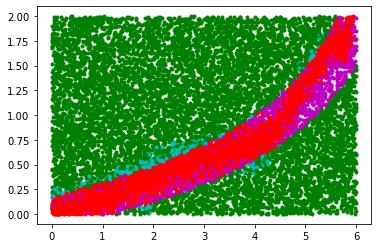

11000 0.20281437396528007
0.17302412305993675 -0.2770638547674906 0.17778835737879484 0.07606886923696025
[ 1.28749092  1.20212775  1.08914204  0.93284334  0.71023936  0.39770684
 -0.03908218 -0.61179045 -0.78615669  7.37833771]


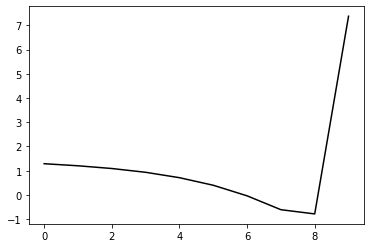

12000 0.18383571276232902
0.1714565299642 -0.27529685908283524 0.17759363994849528 0.07588716158174155
[ 1.3179863   1.23130818  1.13228638  0.99601253  0.80102206  0.50684536
  0.06224486 -0.53954168 -0.74625682  7.40172478]


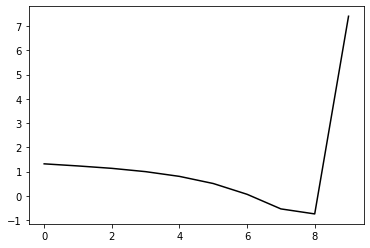

13000 0.22591742444706062
0.1706947842287156 -0.2754897631597058 0.1780377291311471 0.07628918762026393
[ 1.30077781  1.22391325  1.12948923  0.98364676  0.76978543  0.48089312
  0.0660039  -0.51035339 -0.71396409  7.40342174]


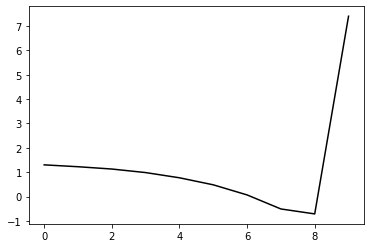

14000 0.2076821396771025
0.16906093405638287 -0.275176767903874 0.179308146347565 0.07118504682580307
[ 1.30855768  1.20293022  1.1016529   0.9806512   0.8017527   0.52986951
  0.13709569 -0.40444683 -0.58667417  7.42675885]


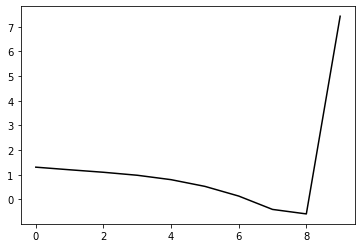

15000 0.20148547423203655
0.16681340071562767 -0.2723624109533896 0.17718664977296764 0.07635268837627704
[ 1.32080194  1.18098941  1.07049889  0.96935928  0.80421057  0.52820357
  0.11778752 -0.43318959 -0.60384648  7.4368754 ]


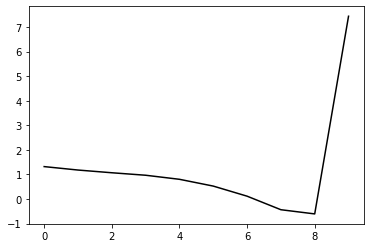

16000 0.25906065944627293
0.16662348116829628 -0.2726474258763188 0.17772403428651368 0.07483738354514284
[ 1.31649929  1.20458093  1.11181356  0.97003436  0.75687607  0.4648434
  0.05718571 -0.48831749 -0.65011679  7.44421714]


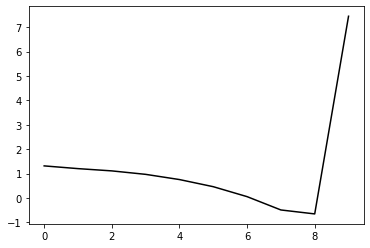

17000 0.13717749129252368
0.16887828402584998 -0.27377219885808507 0.17894012515209776 0.07676017297125508
[ 1.29164587e+00  1.21526777e+00  1.11337909e+00  9.48401551e-01
  7.24952941e-01  4.28345670e-01  5.80959893e-03 -5.54989607e-01
 -7.11264685e-01  7.40431944e+00]


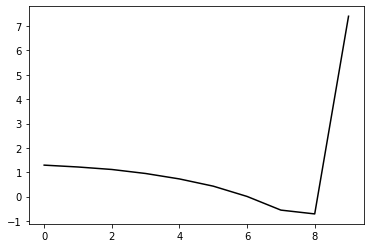

18000 0.19573691069167826
0.16839899321099133 -0.2743048997699464 0.18073558836405393 0.07789601274735017
[ 1.30719682  1.1940308   1.12409346  0.9994588   0.78290044  0.47835389
  0.06228193 -0.48838521 -0.63301926  7.40627877]


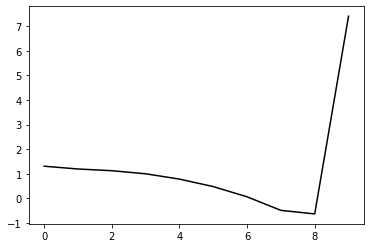

19000 0.17410004453918443
0.1739895745601091 -0.26703417875784224 0.1792616525690972 0.07664215628347497
[ 1.29968153  1.18246858  1.1175317   0.99349959  0.77617868  0.46457366
  0.01613472 -0.57979912 -0.76944664  7.34222576]


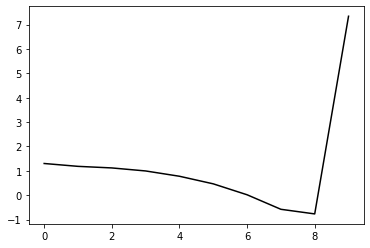

20000 0.18021826810452105
0.17056155654915306 -0.2670869466995272 0.179358236441341 0.07564948526355013
[ 1.2927771   1.18721492  1.06872493  0.91152568  0.70407965  0.4145773
 -0.00928567 -0.59259702 -0.79044074  7.38418859]


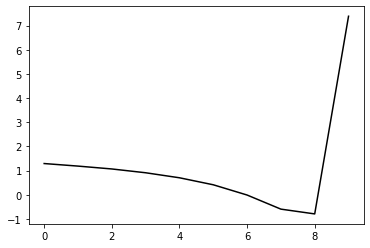

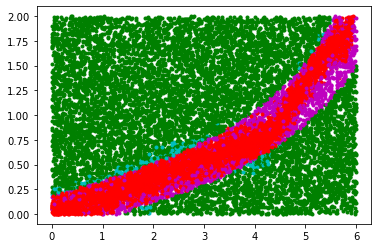

21000 0.2273605975476016
0.17365241019632735 -0.2716922373826144 0.18392985111799265 0.07537458244079409
[ 1.26188974e+00  1.19693228e+00  1.09637524e+00  9.48509520e-01
  7.32950260e-01  4.26922637e-01  4.35988762e-03 -5.39729417e-01
 -6.80357430e-01  7.41286568e+00]


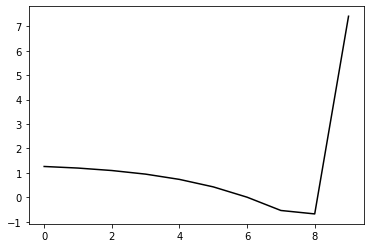

22000 0.18185915645736123
0.17304260817353298 -0.2701644023835327 0.18315769388346692 0.07972482752466581
[ 1.31276585  1.21153282  1.12535719  0.97022607  0.74644801  0.45386273
  0.02722051 -0.55507817 -0.72638741  7.38274123]


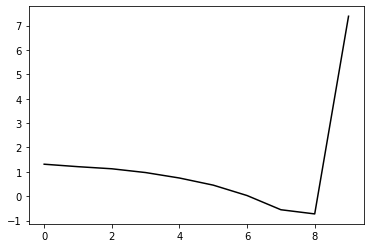

23000 0.16461925075666717
0.1724643232628007 -0.2692631000347047 0.1829995659871247 0.07694725667994458
[ 1.32107998  1.20475222  1.09360316  0.95720512  0.7638898   0.47945569
  0.06754813 -0.49498321 -0.66477111  7.42869547]


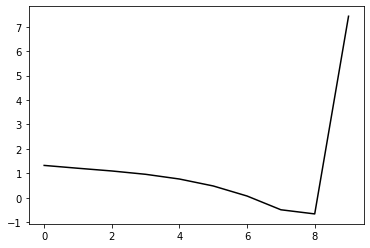

24000 0.17810618875878065
0.17128229134611278 -0.2642229612157381 0.18085922522635275 0.0746813320533422
[ 1.30738952e+00  1.21133186e+00  1.08989375e+00  9.42070104e-01
  7.29314199e-01  4.25734709e-01 -4.69485300e-04 -5.66347655e-01
 -7.47294973e-01  7.40877343e+00]


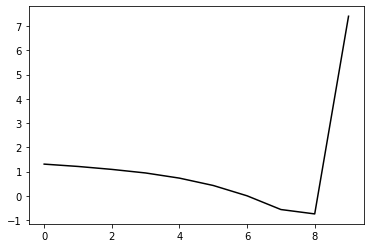

25000 0.22667575320777675
0.1689311673694294 -0.268383586653694 0.18403553141039844 0.07574231784532809
[ 1.32559415  1.22366174  1.14742191  1.00751269  0.78786548  0.49468946
  0.07956433 -0.48569835 -0.66146123  7.41783526]


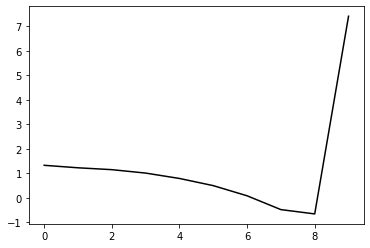

26000 0.12595188968853505
0.16588564172404563 -0.26557966123214133 0.18212517401401798 0.07675952938350442
[ 1.32221999  1.23076108  1.1206204   0.9688302   0.75821306  0.48216588
  0.09066385 -0.45676211 -0.62392592  7.41282454]


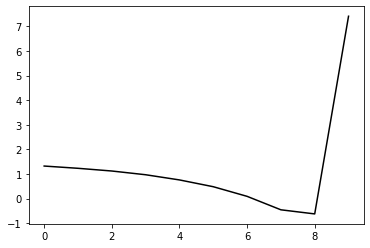

27000 0.15528745803515212
0.16143071679986917 -0.26536245812012743 0.18140488938271038 0.07351108629814496
[ 1.30767423  1.190829    1.03148994  0.85271492  0.6498386   0.38068364
 -0.00834123 -0.54167287 -0.69161806  7.40898451]


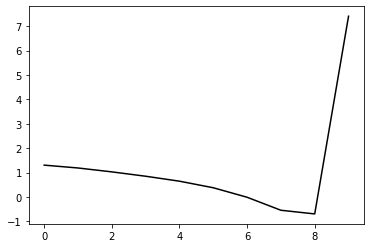

28000 0.2039029938681115
0.16275954549677524 -0.2657730195487266 0.18247672755019392 0.07584252258315598
[ 1.32115684  1.25473258  1.17876454  1.03350468  0.80504159  0.49645809
  0.07783065 -0.45595172 -0.58402871  7.41393762]


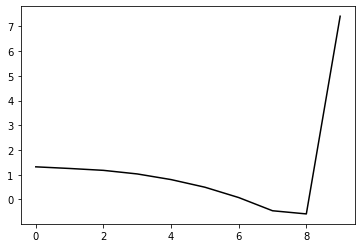

29000 0.21180451999013453
0.16726332762826288 -0.26434717899623367 0.1829635592745599 0.07452149809961373
[ 1.30624745  1.20262873  1.1238046   0.97317713  0.73739665  0.42959299
  0.01663839 -0.52308607 -0.65410234  7.37991929]


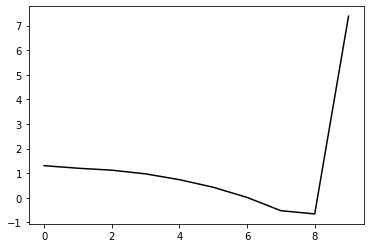

30000 0.2580636128709508
0.16925935393804986 -0.2600720648887055 0.18145716729735198 0.0731748387396995
[ 1.31101107  1.19323073  1.10559858  0.96680049  0.7503405   0.4492026
  0.02229812 -0.53810737 -0.68037376  7.37223678]


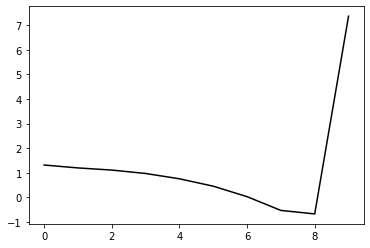

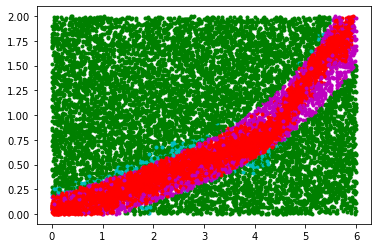

31000 0.24632416004973037
0.1644366515941345 -0.2626316186037888 0.18190722374888 0.0734600460670521
[ 1.3187378   1.21027241  1.05911158  0.88648553  0.67337455  0.37603603
 -0.0472739  -0.61189937 -0.76300242  7.39042036]


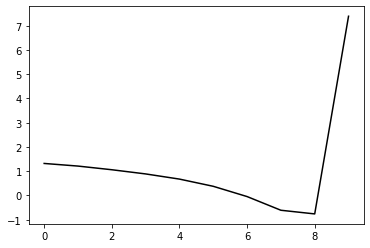

32000 0.17550407809040972
0.16486562325022927 -0.262636855263257 0.18363192533586786 0.07387147494392042
[ 1.34861031  1.25899085  1.16506327  1.02201297  0.81133319  0.51970679
  0.10737093 -0.44191239 -0.58386674  7.43370418]


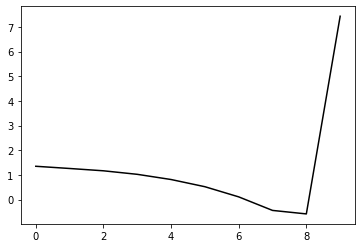

33000 0.1397573991167813
0.16443455183177574 -0.2594629851104913 0.1819593369475227 0.07302129964109663
[ 1.35154768  1.26762946  1.15372967  0.99044413  0.77074475  0.48105677
  0.07673411 -0.46775375 -0.61788255  7.45157471]


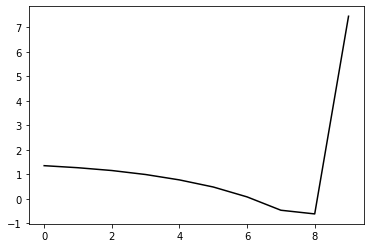

34000 0.1832952586076642
0.16420844671855891 -0.26215071873529505 0.18380737907080627 0.07275070020182108
[ 1.32318472  1.20582142  1.11930289  0.97258249  0.74779566  0.45638658
  0.05861226 -0.46679813 -0.58175168  7.43121665]


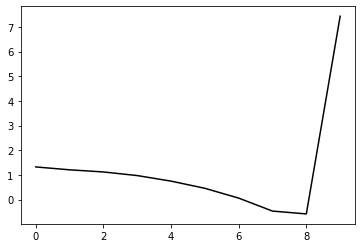

35000 0.19301128183738211
0.1628612679588419 -0.25908776872270367 0.18139228983365657 0.07078209444532388
[ 1.29248362  1.19746288  1.09372695  0.94537967  0.73384549  0.44584849
  0.04216127 -0.48808851 -0.59909014  7.42615844]


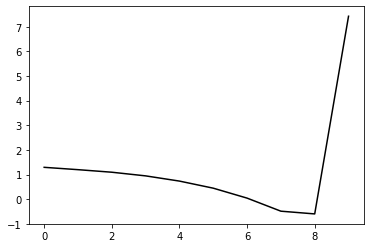

36000 0.26021332401124436
0.16749664140624942 -0.2546146283329296 0.18035254788155727 0.0753886082539155
[ 1.28059539e+00  1.17111226e+00  1.10095087e+00  9.71524544e-01
  7.54840136e-01  4.46117808e-01  2.39554509e-04 -5.80778357e-01
 -7.22443304e-01  7.38477626e+00]


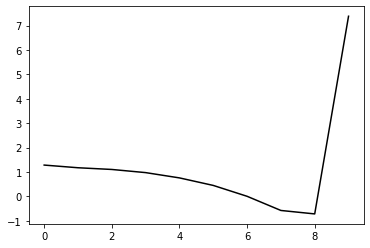

37000 0.21868909512604828
0.16183543199204473 -0.25763967162443463 0.18218210952189537 0.07271821083110282
[ 1.29526231  1.17969004  1.04246253  0.89755379  0.70301512  0.42208775
  0.00972815 -0.55307945 -0.70583218  7.38347184]


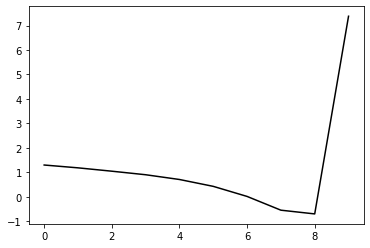

38000 0.19424439142195585
0.15990160248365032 -0.25948965542186747 0.18381559329778158 0.07419309409514888
[ 1.34623722  1.19664867  1.08247485  0.9791229   0.81033315  0.53851501
  0.13821194 -0.39887422 -0.53824935  7.44531204]


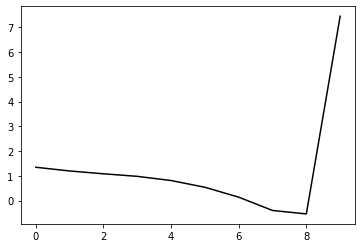

39000 0.20708635852970397
0.1616709374862247 -0.25593985372439276 0.1822533107200619 0.07245897434192985
[ 1.33244239  1.21981766  1.13228397  1.00649637  0.80303772  0.51563221
  0.10661493 -0.44175899 -0.59470581  7.43729207]


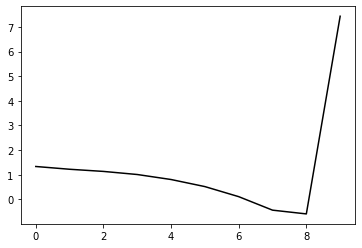

40000 0.15398724787002874
0.166463454362111 -0.2551814442207418 0.18293980972779758 0.07300314997137348
[ 1.28314698  1.23396902  1.17852579  1.04597327  0.82760152  0.52725784
  0.10754412 -0.44575635 -0.59737771  7.39242221]


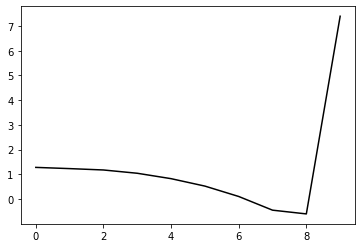

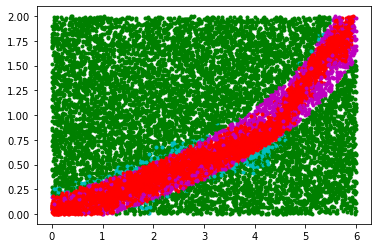

41000 0.21379110588066144
0.1663813851754647 -0.2586832042784777 0.18529806541672164 0.07563259260058956
[ 1.32322517  1.21845358  1.14304337  1.00810746  0.7937974   0.50007776
  0.08368925 -0.46808485 -0.60175011  7.4005279 ]


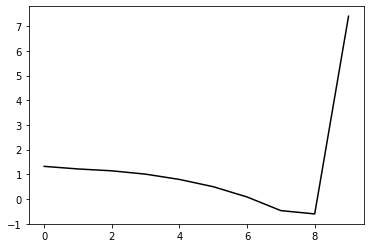

42000 0.21292091227354767
0.16121498101592163 -0.2586981495405453 0.18396057331215424 0.07476862592473817
[ 1.33313348  1.2335563   1.09395229  0.90897014  0.67944346  0.37496488
 -0.04860575 -0.6098358  -0.76829174  7.39430289]


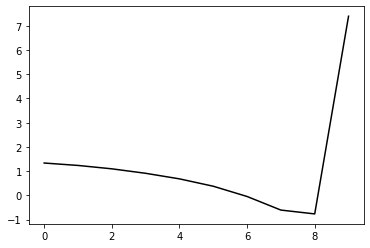

43000 0.1589418949577754
0.16460756341084987 -0.2587015861319431 0.18526920406318265 0.07555803402131628
[ 1.28499463  1.19409319  1.11129317  0.95240833  0.72520513  0.43042298
  0.01506234 -0.5445159  -0.7015726   7.37856878]


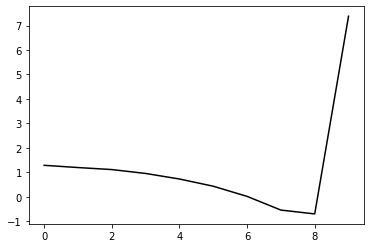

44000 0.19634751962554628
0.16412504996495228 -0.25907004063254463 0.18536422177725348 0.07745229030460735
[ 1.32581478  1.15852195  1.05233127  0.92741965  0.72378985  0.43473992
  0.03162294 -0.51885022 -0.67007936  7.41919663]


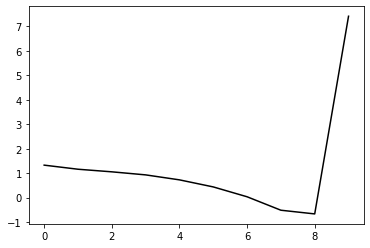

45000 0.14238010725986827
0.16222709578623004 -0.25573173466460836 0.18397986162479646 0.07478565498278197
[ 1.29752354  1.23607414  1.12975392  0.97580619  0.77195789  0.47407918
  0.04204833 -0.53231652 -0.71535416  7.40356816]


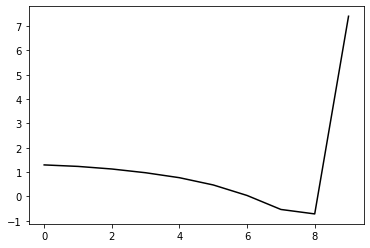

46000 0.2737465189933951
0.16563241046623028 -0.2535289142232974 0.1834509536641861 0.0767120175375578
[ 1.29108463e+00  1.21722121e+00  1.14069899e+00  9.90095626e-01
  7.50285226e-01  4.31433269e-01  1.24456011e-03 -5.65390574e-01
 -7.44568255e-01  7.35374413e+00]


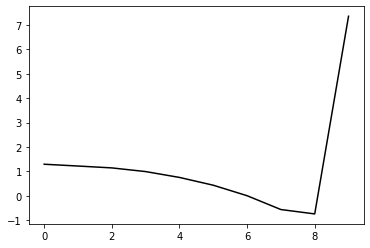

47000 0.19304321578666012
0.16878085389211583 -0.2527551380011871 0.18428243275281778 0.07633117961602408
[ 1.31752225  1.21352399  1.1361953   0.99206869  0.76685361  0.46670762
  0.04033622 -0.53805107 -0.72503257  7.37990921]


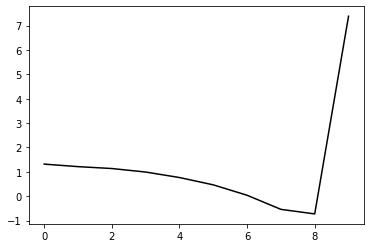

48000 0.2030305324608798
0.16805838272123552 -0.24915833847144012 0.18285024254400473 0.07443367312641043
[ 1.34472701  1.22983733  1.15010754  1.02243906  0.80611743  0.49016382
  0.04202968 -0.54263707 -0.7294579   7.39475614]


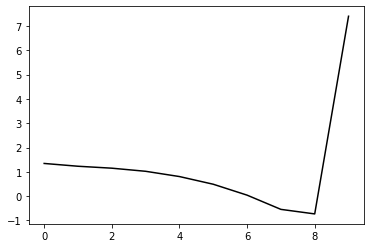

49000 0.16940775072931777
0.16936971655954156 -0.2552396433153877 0.18691400213264972 0.07854780732584142
[ 1.31550754  1.21852123  1.13789416  0.98060246  0.7353621   0.41506105
 -0.01324816 -0.57922248 -0.73971868  7.36332724]


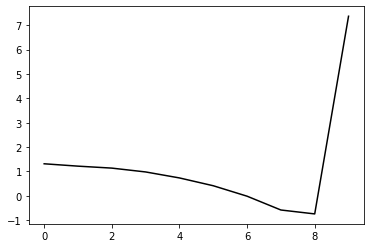

50000 0.24693244237967338
0.16953456839816 -0.2516979303216191 0.18567054856686155 0.07940781276141208
[ 1.3231416   1.22720673  1.14800019  1.01434287  0.79532972  0.48430807
  0.04840782 -0.53480073 -0.71276718  7.40287894]


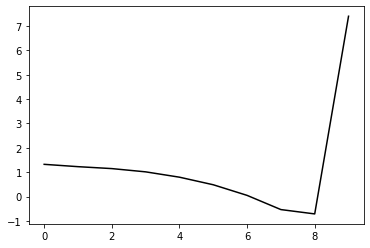

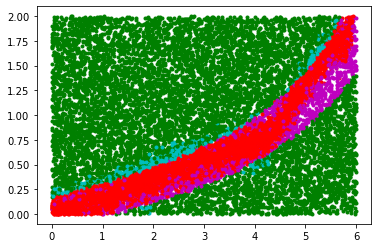

51000 0.1701800107401785
0.17333807537125626 -0.2520459769949676 0.18736217162102686 0.07674569223621167
[ 1.27434226  1.23428579  1.1450665   1.02194773  0.82718275  0.51682301
  0.06105068 -0.54922507 -0.75332812  7.40169699]


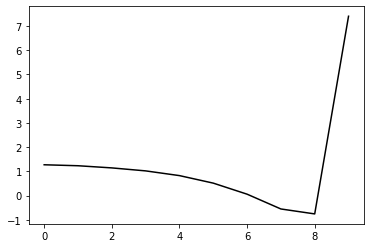

52000 0.2646140491138821
0.1667102406382975 -0.2473791393218764 0.18279699981471254 0.07771449886576665
[ 1.27646082  1.18836712  1.08238772  0.93235439  0.72586101  0.42306341
 -0.03267882 -0.66365037 -0.91183594  7.34784056]


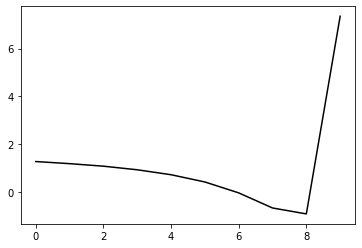

53000 0.15461048631516647
0.1616592799119646 -0.25410424784863644 0.18597331004148898 0.07910987894861524
[ 1.30120044e+00  1.14254868e+00  1.03412868e+00  9.06886149e-01
  7.11741514e-01  4.21552531e-01  8.36769848e-04 -5.76030222e-01
 -7.74603339e-01  7.37306031e+00]


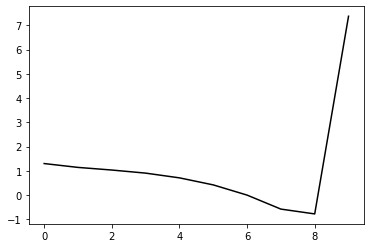

54000 0.23327450390313798
0.1632160675905296 -0.24600290484597545 0.18191251225512026 0.07511504523501446
[ 1.28471531e+00  1.14136809e+00  1.05127820e+00  9.23632581e-01
  7.19792964e-01  4.22277533e-01 -2.67747701e-03 -5.77262563e-01
 -7.83948258e-01  7.40095345e+00]


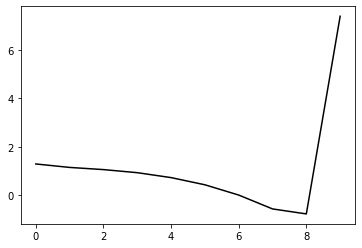

55000 0.18229009963144233
0.16384780505228708 -0.25142463650268254 0.18466522525513582 0.07712529460528729
[ 1.29931882  1.1893079   1.11443051  0.98009641  0.75853984  0.4595135
  0.03750962 -0.53207942 -0.71789535  7.43249391]


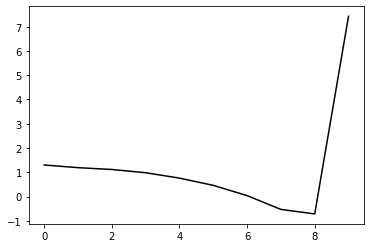

56000 0.2565373786149455
0.16363572149822306 -0.25055142527620056 0.18482062837936392 0.07530275486643263
[ 1.28311436e+00  1.16453401e+00  1.03513902e+00  8.99841051e-01
  7.10962861e-01  4.23673797e-01 -3.73065085e-03 -5.82978330e-01
 -7.74442324e-01  7.31977600e+00]


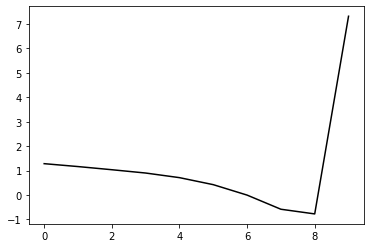

57000 0.17826703843337846
0.16255360069696365 -0.2507929940642103 0.1851636183620159 0.07367752873211852
[ 1.27522523  1.19233004  1.09221972  0.9570234   0.76740603  0.48341804
  0.06615227 -0.49189307 -0.66479647  7.4594965 ]


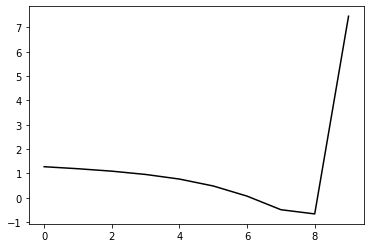

58000 0.17829716547328597
0.1628222322910551 -0.24714436943298265 0.18272730356227662 0.07937070722335424
[ 1.26751121  1.15268305  1.06480109  0.93044595  0.70395463  0.38310887
 -0.05189701 -0.61496001 -0.76985174  7.35153781]


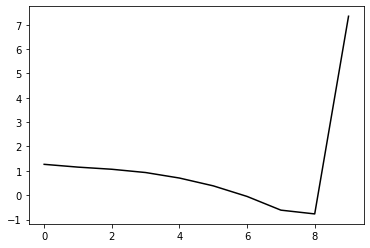

59000 0.28272103191298287
0.15752273823697527 -0.2555062537316302 0.18695350967303678 0.08137197239326588
[ 1.29525638  1.14799364  1.00411166  0.85425108  0.65727989  0.37032172
 -0.04638996 -0.60499626 -0.73953466  7.39352424]


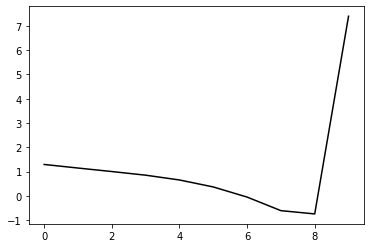

60000 0.16558388166724128
0.16703251701648505 -0.24851986910527812 0.1845732284135961 0.07757744841527194
[ 1.24891578  1.11076338  1.00197184  0.85778092  0.640561    0.3335373
 -0.09918331 -0.67933415 -0.84789301  7.38658817]


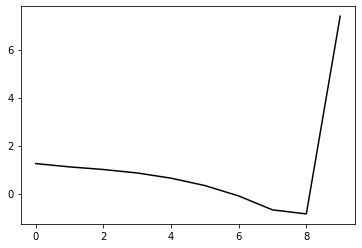

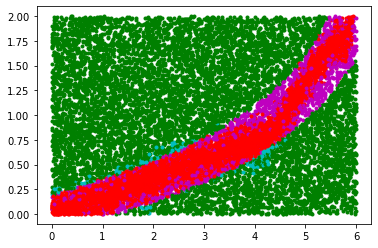

61000 0.14713108324292226
0.16613067063990555 -0.25008776950063716 0.18582860656437847 0.08010823636720861
[ 1.27505499  1.16018568  1.06372004  0.89225682  0.64682403  0.34377729
 -0.06370864 -0.6088949  -0.74901083  7.35859789]


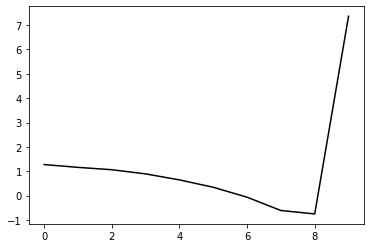

62000 0.1643628855783592
0.16706517655868977 -0.25081685419048283 0.18710625548421186 0.0758319946174479
[ 1.26539718  1.19517626  1.09343293  0.94790804  0.73362365  0.4310138
  0.01174909 -0.53456718 -0.66104497  7.40727862]


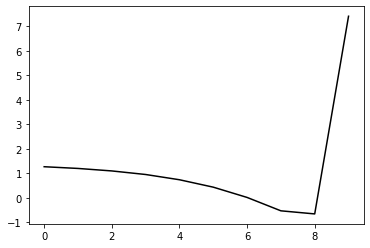

63000 0.1729293774385966
0.16279054341844462 -0.2455206611624581 0.18369000009465797 0.07866313076232276
[ 1.27538687  1.16289959  1.06750404  0.93115008  0.70834372  0.39546175
 -0.03945316 -0.5984717  -0.72410241  7.43324111]


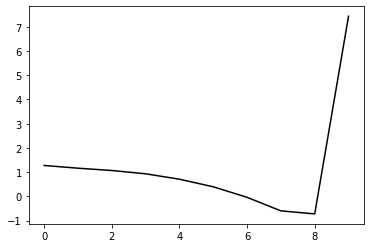

64000 0.2536580285619565
0.16017438099251713 -0.2442179891806123 0.18292052776864748 0.07808591584498326
[ 1.29743391e+00  1.15993545e+00  1.06128240e+00  9.37897063e-01
  7.41591544e-01  4.39096221e-01  4.91361511e-03 -5.53920369e-01
 -6.81118668e-01  7.44227110e+00]


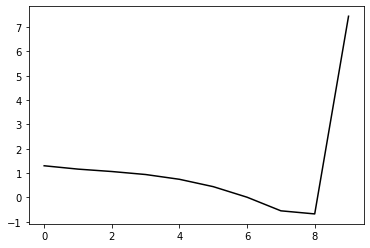

65000 0.25192708393161606
0.16137488385500093 -0.2486248078367144 0.18629911411777283 0.08162456116322257
[ 1.2856407   1.20208547  1.1262187   0.98537348  0.76209602  0.45609408
  0.02476651 -0.54621155 -0.68926647  7.39746113]


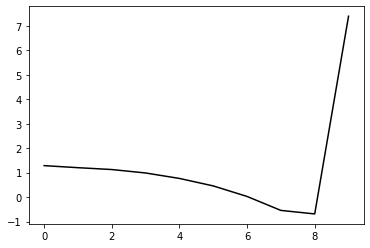

66000 0.24418282524370663
0.15945761045083395 -0.2488483896604132 0.18595024249665848 0.07707526347546943
[ 1.26840236  1.14782175  0.99179566  0.80774468  0.58382261  0.28335122
 -0.13133235 -0.6841587  -0.82066765  7.37717476]


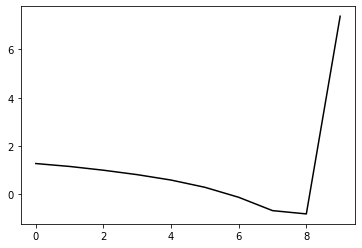

67000 0.2948210033987032
0.1590751110647387 -0.25017671530634483 0.1875683983450593 0.07630429406400013
[ 1.26608205  1.1345572   1.01100722  0.86683694  0.65565043  0.35133643
 -0.07555411 -0.62580023 -0.74919739  7.36799322]


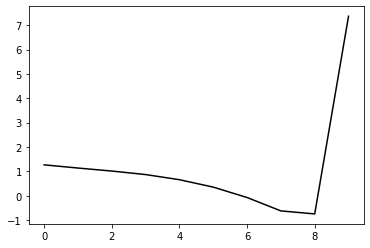

68000 0.2106252959026766
0.15595517423661298 -0.2461084749918178 0.18473732136541557 0.07599308308566488
[ 1.27475928  1.19131428  1.07820061  0.92605494  0.71896815  0.41874022
 -0.01334246 -0.58462292 -0.73636237  7.4066165 ]


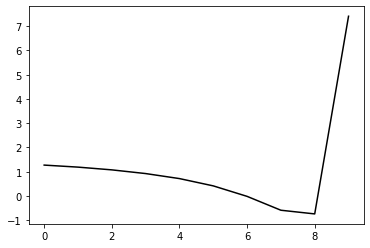

69000 0.19151000081883657
0.15213203967488753 -0.24922329930718315 0.18589029083304665 0.07656813545397884
[ 1.28607443  1.21013814  1.09854576  0.94354304  0.74265786  0.46724088
  0.06030751 -0.50419447 -0.66956541  7.41258437]


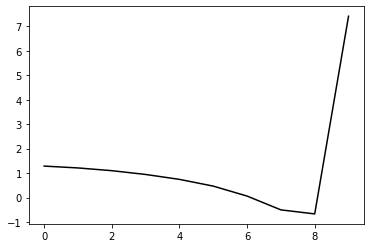

70000 0.16976912774211203
0.14997399703294775 -0.25057272446029266 0.18657294353530404 0.07514089925293292
[ 1.26202177  1.1540746   1.02625779  0.866054    0.66119759  0.37387707
 -0.03695502 -0.58377231 -0.73301619  7.3941864 ]


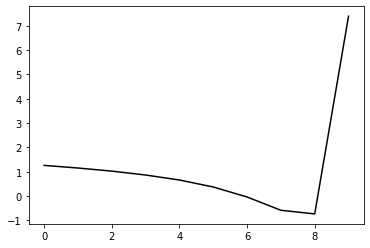

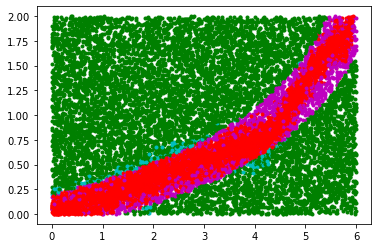

71000 0.22871672141143398
0.1551073177481779 -0.2424702692159362 0.18281426736752807 0.07675113800373563
[ 1.28181741  1.16055728  1.07840929  0.9495674   0.73926757  0.44274907
  0.01837272 -0.55117754 -0.72216557  7.37397311]


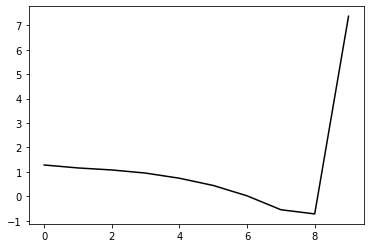

72000 0.14886914892190825
0.15369967191005102 -0.24835959833422075 0.18608069162064542 0.07853400684909563
[ 1.25974434  1.16525485  1.0490404   0.89966113  0.70004882  0.41041527
 -0.01189534 -0.56950361 -0.71568343  7.40091936]


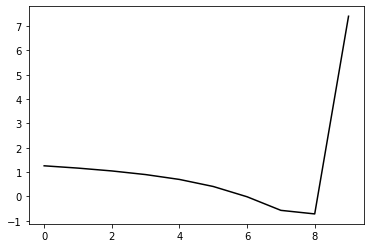

73000 0.22195181285692236
0.15241093611306192 -0.2507908776418072 0.1879754507408951 0.0748247256835721
[ 1.27673347  1.16782674  1.06321442  0.90720295  0.69324263  0.4073976
  0.0094244  -0.52982564 -0.67321175  7.42221942]


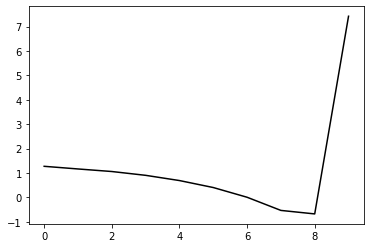

74000 0.22885687393533066
0.15791892294163068 -0.24470091175751954 0.18520501326820132 0.07588130157489867
[ 1.25272096  1.16837532  1.08706053  0.95131351  0.73907055  0.44745382
  0.02959668 -0.53580709 -0.70239804  7.37840089]


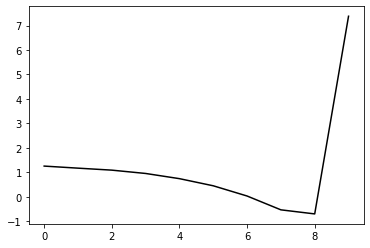

75000 0.15653890583375304
0.1532101398477419 -0.24754038222387256 0.18555732235128547 0.07708597627104288
[ 1.28560965  1.13478335  1.01541334  0.88039266  0.70174641  0.43642895
  0.04279854 -0.48631179 -0.61678247  7.41549259]


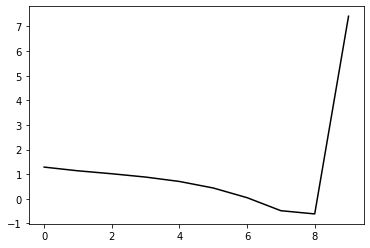

76000 0.20315971431504543
0.15219320612963563 -0.2474351148623153 0.18550403025398537 0.07604557048438042
[ 1.28214709  1.17062868  1.0654689   0.92229367  0.72348548  0.43864239
  0.03777572 -0.48404856 -0.60365113  7.44098335]


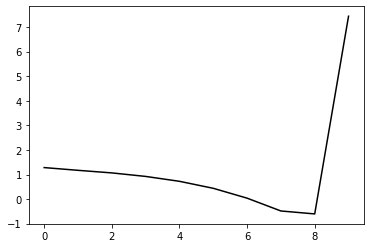

77000 0.16767874663030521
0.15476583272895836 -0.25150871750261244 0.18765473644291403 0.07814317983303816
[ 1.26325784  1.17487139  1.08739755  0.93863625  0.71284538  0.41703505
  0.01646618 -0.509387   -0.61317241  7.42397479]


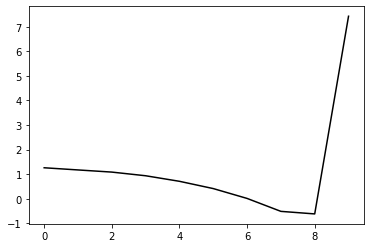

78000 0.1552896438777291
0.15742035310708669 -0.2501663289449098 0.1867534494834376 0.08120180411618443
[ 1.27110034  1.17285067  1.09724894  0.9560727   0.73290259  0.42065235
 -0.01603694 -0.57327345 -0.68619032  7.38085484]


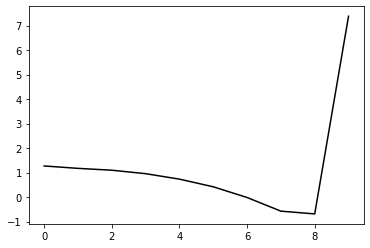

79000 0.10600082470257816
0.15542852381179478 -0.25041552664682765 0.18692969059462392 0.07954980804646393
[ 1.26544971  1.12773779  1.00541717  0.87877715  0.70764541  0.43818998
  0.0346848  -0.50910484 -0.62436988  7.42656152]


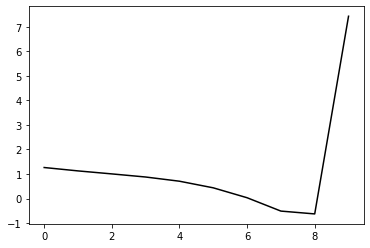

80000 0.20887356124384976
0.15296010738862664 -0.24524288464359323 0.18368860080634622 0.07717140395472837
[ 1.26315869  1.15193768  1.07340449  0.93702127  0.71949262  0.42878995
  0.02458266 -0.52136582 -0.6677312   7.37332763]


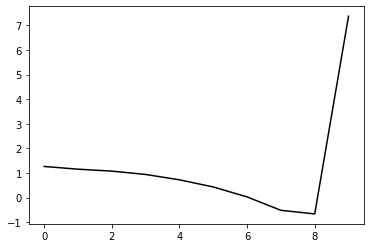

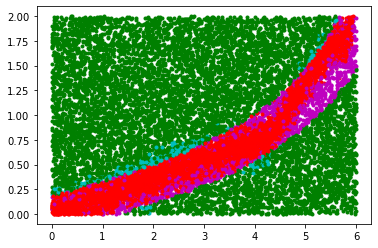

81000 0.2292437908498097
0.1547162774230281 -0.2460230330896918 0.1857203160546063 0.07722049142289925
[ 1.28524438  1.18570722  1.09562763  0.95583187  0.7449498   0.451968
  0.04692415 -0.49115495 -0.62467982  7.45769882]


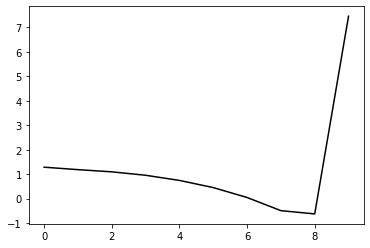

82000 0.2540608337111415
0.153302971642211 -0.24697872961156234 0.1859166013052006 0.07496423371123641
[ 1.28026027  1.17828092  1.04190824  0.88408874  0.67656372  0.37578471
 -0.05871872 -0.62726722 -0.77774019  7.38582736]


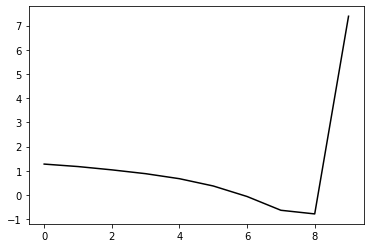

83000 0.2548241852490898
0.15436239427873708 -0.24481188570469314 0.18524245258774388 0.07429357167045889
[ 1.30309474  1.14610247  1.01756634  0.88275751  0.70666362  0.44538967
  0.05175091 -0.49394288 -0.6401407   7.45220591]


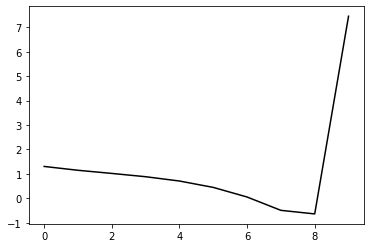

84000 0.24020786941403036
0.15510758736388172 -0.24546378234264202 0.18558249535267965 0.07371370747485081
[ 1.26703529  1.1258119   1.02585373  0.89045021  0.69265203  0.40214093
 -0.01153975 -0.55675277 -0.70216911  7.39919753]


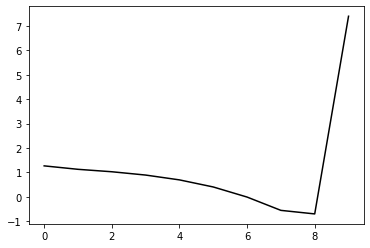

85000 0.21742205252166819
0.15491925983083465 -0.24542374063649222 0.1849619985809633 0.07506453772343068
[ 1.26464279  1.16537073  1.05537394  0.91230684  0.71543935  0.42935481
  0.00774391 -0.55961659 -0.7194687   7.39560523]


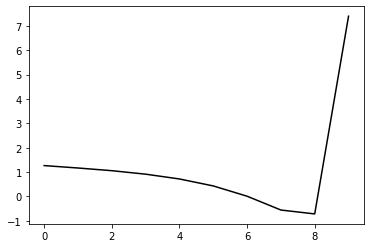

86000 0.1919853268175852
0.15448154913498593 -0.24992705984894367 0.1884163729233298 0.07588582418372793
[ 1.30651783  1.20019253  1.11506153  0.9634538   0.74337924  0.4610128
  0.07424225 -0.4466559  -0.57416937  7.4168836 ]


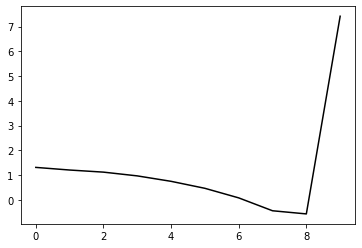

87000 0.23923762731151982
0.15610445533400757 -0.24678628874860473 0.1858352720250548 0.07494974095784036
[ 1.28390194  1.17286591  1.02694884  0.85895896  0.65019719  0.3513785
 -0.07707068 -0.64109373 -0.79951488  7.38094907]


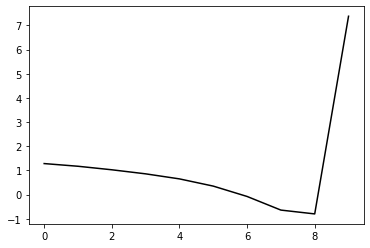

88000 0.2297479370484494
0.15899186336628196 -0.24658164309816016 0.18752484092015997 0.07511730647445977
[ 1.29399221  1.17818774  1.0653944   0.91249994  0.70606194  0.41176807
 -0.01949591 -0.5953135  -0.75925962  7.39218482]


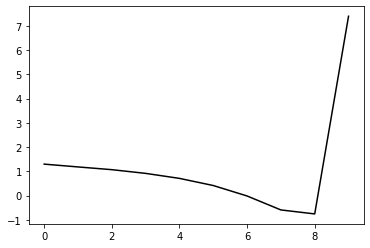

89000 0.1377972024815882
0.15775908066221633 -0.2456746076638475 0.18658949080139617 0.0740364915815435
[ 1.28914947e+00  1.16224680e+00  1.04576156e+00  8.98557111e-01
  6.97997018e-01  4.19602820e-01  5.99373266e-03 -5.66700294e-01
 -7.49736825e-01  7.38795088e+00]


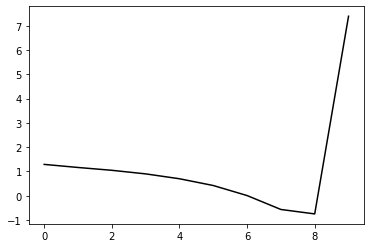

90000 0.19511154252166465
0.1602033272821252 -0.25196672871887577 0.1910865443728919 0.07490459892519807
[ 1.28948381  1.20336567  1.07254361  0.93161183  0.75066787  0.47594374
  0.06520391 -0.496379   -0.66674713  7.41352582]


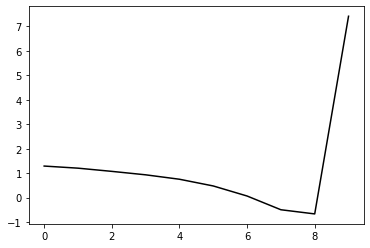

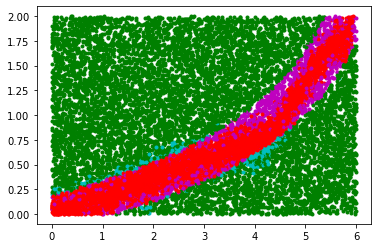

91000 0.22446882198304985
0.15948757579165707 -0.24496326389758946 0.18650812776802714 0.0753692055461015
[ 1.29869042  1.19709516  1.11025914  0.96424396  0.73220827  0.42144139
  0.00851429 -0.53217466 -0.68996516  7.38748491]


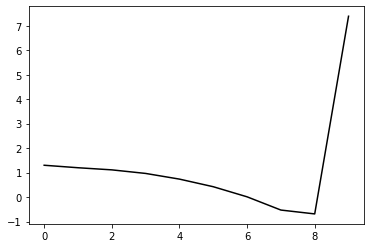

92000 0.23795990086447782
0.15555510015085117 -0.24676112264871974 0.18697148525433605 0.07493954219761198
[ 1.29264181  1.17329797  1.01850469  0.84777304  0.63800879  0.34824214
 -0.06217872 -0.61152308 -0.76124819  7.38952542]


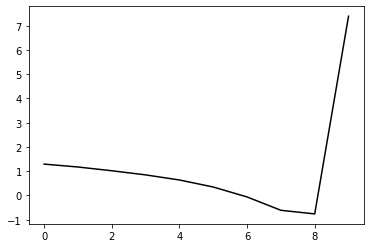

93000 0.17813431980977568
0.1616404642047835 -0.24288684588591236 0.18635526775837818 0.07618138316789945
[ 1.26271961  1.17329526  1.08934116  0.95276463  0.73866185  0.44005259
  0.0080722  -0.5733259  -0.74989637  7.35751739]


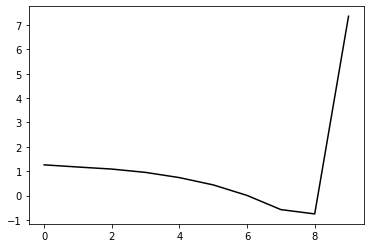

94000 0.17448690297481906
0.16312943182637543 -0.24722061166210405 0.18902250935915882 0.0800107002054467
[ 1.28049962  1.1653661   1.07643122  0.92798994  0.70140378  0.396108
 -0.03550308 -0.60796909 -0.76454083  7.37025615]


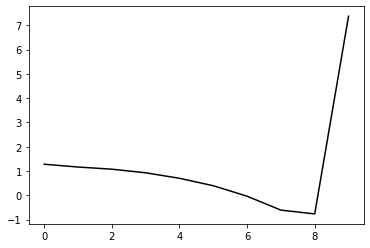

95000 0.2498677116842449
0.161029806715767 -0.24456881637641217 0.1871628122743941 0.07983507084831283
[ 1.27961116  1.19073112  1.09468719  0.95845555  0.74952489  0.45201694
  0.02618194 -0.54955499 -0.72386691  7.39915102]


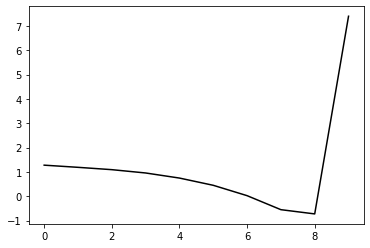

96000 0.2088633872811935
0.16278032377716248 -0.2409300718027415 0.18476590858934064 0.07798813912128753
[ 1.23356165  1.14608915  1.04203883  0.89435815  0.68081694  0.37410908
 -0.06311275 -0.65497332 -0.85330397  7.37140808]


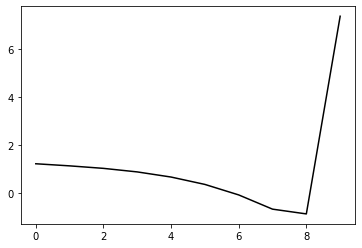

97000 0.21100541876052956
0.15984131747902566 -0.24720455067395597 0.188197943816659 0.08040042755476265
[ 1.29667123  1.21879479  1.13813677  0.99023452  0.76458363  0.46156438
  0.03523199 -0.53576143 -0.71084846  7.38491435]


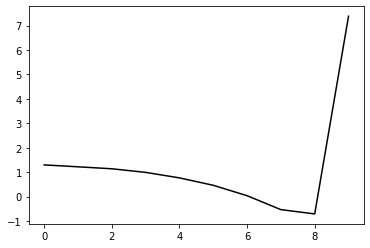

98000 0.2579644909103588
0.16092500640050092 -0.2436697679550423 0.1862171002799269 0.07492477248671249
[ 1.29489669  1.17774517  1.06826702  0.91463625  0.69763009  0.39803564
 -0.02264604 -0.58660306 -0.76303557  7.38934001]


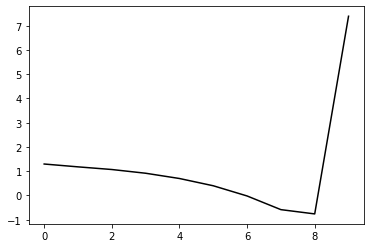

99000 0.17810406296374
0.16124964740730882 -0.24692320916830363 0.18852568639437065 0.07610201525761615
[ 1.29485875  1.16329851  1.06440082  0.91090192  0.68254522  0.38120248
 -0.03267228 -0.5886642  -0.74360509  7.38849843]


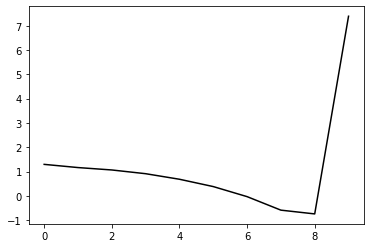

In [27]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

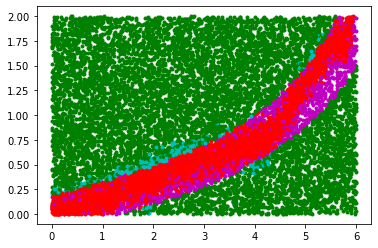

In [28]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

99990 0.18093231570464335
0.16041162781936408 -0.2454881533416929 0.18818440677965506 0.07678865303230896
[ 1.32684947  1.17123679  1.06436367  0.9288177   0.74004645  0.45525472
  0.03747635 -0.52578111 -0.6857764   7.43607617]


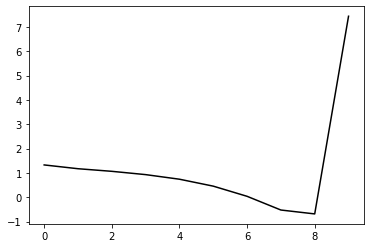

([<matplotlib.lines.Line2D at 0x1b11a69fd88>], None)

In [29]:
print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
plt.plot(h.numpy(), 'k-'), plt.show()